In [1]:
import pandas as pd
import numpy as np
import ast

import missingno as msno
import seaborn as sns 
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from nltk.stem import WordNetLemmatizer
wlt = WordNetLemmatizer()
import gensim
from gensim import corpora
from gensim import models
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from PIL import Image
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from nltk.util import ngrams
from textblob import TextBlob
%matplotlib inline 

## This notebook is divided in following parts:
### Initial analysis:
#### 1. Cleaning Tweets
#### 2. Location-wise Analysis
#### 3. Sentiment Analysis
### A. Tweets EDA
### B. Topic Modelling
### C. Segmenting the Twitter users
### D. Identifying the micro-influencer

In [2]:
df = pd.read_csv('disney_plus_3k.csv')
df.head(2)

,Unnamed: 0,author_id,statuses_count,location,verified,followers_count,friends_count,listed_count,favourites_count,tweet_id,text,created_at,lang,retweet_count,hashtags,favorite_count
0,0,1552675995081183233,271,México/CDMX,False,118,45,0,1336,1628907212088176644,"I said before i was kind of a weeb.\nSo here, ...",2023-02-23 23:58:37,en,28,"[{'text': 'save101dalmatianstreet', 'indices':...",95
1,1,723532208179404800,56702,"London, England",False,765,2383,10,6600,1628906869048713216,#Extraordinary is an absolute must-see #TVShow...,2023-02-23 23:57:15,en,0,"[{'text': 'Extraordinary', 'indices': [0, 14]}...",0


In [3]:
df.drop(columns = ['Unnamed: 0'],inplace=True)
df.head(2)

,author_id,statuses_count,location,verified,followers_count,friends_count,listed_count,favourites_count,tweet_id,text,created_at,lang,retweet_count,hashtags,favorite_count
0,1552675995081183233,271,México/CDMX,False,118,45,0,1336,1628907212088176644,"I said before i was kind of a weeb.\nSo here, ...",2023-02-23 23:58:37,en,28,"[{'text': 'save101dalmatianstreet', 'indices':...",95
1,723532208179404800,56702,"London, England",False,765,2383,10,6600,1628906869048713216,#Extraordinary is an absolute must-see #TVShow...,2023-02-23 23:57:15,en,0,"[{'text': 'Extraordinary', 'indices': [0, 14]}...",0


In [4]:
df.shape

(2545, 15)

In [5]:
df.columns

Index(['author_id', 'statuses_count', 'location', 'verified',
       'followers_count', 'friends_count', 'listed_count', 'favourites_count',
       'tweet_id', 'text', 'created_at', 'lang', 'retweet_count', 'hashtags',
       'favorite_count'],
      dtype='object')

In [6]:
# Renaming them to avoid confusion as they represent the no. of tweets marked as favourite by the user
df.rename(columns={'favourites_count': 'tweets_or_status_favorited_count'}, inplace=True)
df.columns

Index(['author_id', 'statuses_count', 'location', 'verified',
       'followers_count', 'friends_count', 'listed_count',
       'tweets_or_status_favorited_count', 'tweet_id', 'text', 'created_at',
       'lang', 'retweet_count', 'hashtags', 'favorite_count'],
      dtype='object')

### Missing values check

In [7]:
df.isna().sum()

author_id                             0
statuses_count                        0
location                            972
verified                              0
followers_count                       0
friends_count                         0
listed_count                          0
tweets_or_status_favorited_count      0
tweet_id                              0
text                                  0
created_at                            0
lang                                  0
retweet_count                         0
hashtags                              0
favorite_count                        0
dtype: int64

Location has 972 missing values

### Changing datatype of created_at column to datetime

In [8]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['created_at'].dtype

dtype('<M8[ns]')

## Cleaning the Tweets

In [9]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')

import nltk
import re
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Prajakta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Prajakta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def remove_non_english_words(sentence):
    # Define a regular expression pattern to match words containing English letters or numbers
    pattern = re.compile(r'\b[a-zA-Z0-9]+\b')
    
    # Find all words matching the pattern in the sentence
    words = pattern.findall(sentence)
    
    # Join the words back into a sentence
    filtered_sentence = ' '.join(words)
    
    return filtered_sentence

def preprocessing_review(review):
    review = remove_non_english_words(review)
    # Remove punctuation using regular expression
    review = re.sub(r'[^\w\s]', '', review)
    # Starting by tokenizing the review
    tokens = nltk.word_tokenize(review)

    # Convert all the tokens to lower case
    tokens = [tk.lower() for tk in tokens]

    # Remove all the stop words
    remove_words = stopwords.words('english')
    tokens = [tk for tk in tokens if tk not in remove_words]

    # Join the tokens back into a single string
    return ' '.join(tokens)

In [11]:
df['tweet_cleaned_new'] = df.text.apply(preprocessing_review)
selected_columns = df.loc[:, ['text', 'tweet_cleaned_new']]

# Print the selected columns
selected_columns.head(3)

,text,tweet_cleaned_new
0,"I said before i was kind of a weeb.\nSo here, ...",said kind weeb take save101dalmatianstreet 101...
1,#Extraordinary is an absolute must-see #TVShow...,extraordinary absolute must see tvshow perfect...
2,Why You Should Watch: #Atlanta #FX #DisneyPlus...,watch atlanta fx disneyplus tv https co jkscuz...


## Addressing Location issue in Tweets -Location-wise analysis

In [12]:
df['location'].isna().sum()

972

There are 972 null values here.

In [13]:
df['location'].value_counts()

location
Los Angeles, CA         147
Internet                 87
UK                       67
London, England          47
Location: Classified     39
                       ... 
Dragonstone🤍              1
Etats-Unis                1
ニースの雄叫び✨                  1
South, England            1
Birmingham, England       1
Name: count, Length: 534, dtype: int64

From here we can see that most popular location is Los Angeles, Internet (should go under miscelleaneous/other), UK and so on.

In [14]:
df['location'] = df['location'].str.lower()

# Forming list of all the available unique locations:
location_value_counts = df['location'].value_counts()

# Convert value counts to a dictionary
location_dict = location_value_counts.to_dict()

# Sort the dictionary by values in descending order and get the top 10 items
top_10_locations = sorted(location_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Print the result
print(f'Top 10 locations are: {top_10_locations}')

Top 10 locations are: [('los angeles, ca', 147), ('internet', 87), ('uk', 67), ('london, england', 47), ('location: classified', 39), ('worldwide', 39), ('new york, ny', 38), ('united states', 35), ('the mandalorian era', 30), ('canada', 25)]


Here we can see that location-wise max tweets are from los angeles city, however overall locations seem not proper. 
Thus further I tried combining them by countries to see most users are from which countries

In [15]:
us_states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", 
    "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", 
    "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", 
    "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", 
    "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]

uk_cities = [
    "London", "Manchester", "Birmingham", "Glasgow", "Liverpool","Edinburgh", "Bristol", "Leeds", "Newcastle upon Tyne", "Sheffield",
    "Cardiff", "Belfast", "Nottingham", "Southampton", "Brighton","Portsmouth", "Aberdeen", "Leicester", "Coventry", "Oxford"]

popular_cities_usa = ["New York City","Los Angeles","Chicago","Houston","Phoenix","Philadelphia","San Antonio","San Diego","Dallas","San Jose",
    "Austin","Jacksonville","San Francisco","Columbus","Indianapolis","Fort Worth","Charlotte","Seattle","Denver","Washington, D.C."]

south_america_countries = ['Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Guyana','Paraguay','Peru','Suriname','Uruguay','Venezuela']

south_america_countries_lower = [city.lower() for city in south_america_countries]
popular_cities_usa_lower = [city.lower() for city in popular_cities_usa]

uk_cities_lower = [city.lower() for city in uk_cities]
us_states_lower = [state.lower() for state in us_states]

In [16]:
# Dictionary to store combined counts by country
combined_counts = {}

# Define function to extract country from location
def extract_country(location):
    if 'usa' in location or 'united states' in location:
        return 'USA'
    elif any(state.lower() in location for state in us_states) or any(city.lower() in location for city in popular_cities_usa_lower):
        return 'USA'
    elif 'united kingdom' in location or 'uk' in location or 'england' in location:
        return 'UK'
    elif any(city.lower() in location for city in uk_cities_lower):
        return 'UK'
    elif 'india' in location:
        return 'India'
    elif 'canada' in location:
        return 'Canada'
    elif 'germany' in location:
        return 'Germany'
    elif 'spain' in location or 'barcelona' in location or 'madrid' in location:
        return 'Spain'
    elif any(city.lower() in location for city in south_america_countries_lower):
        return 'South America'
    elif 'australia' in location:
        return 'Australia'
    else:
        return 'Other'

# Combine counts by country
for location, count in location_dict.items():
    country = extract_country(location)
    if country in combined_counts:
        combined_counts[country] += count  
    else:
        combined_counts[country] = count

# Print combined counts
print(combined_counts)

{'USA': 437, 'Other': 824, 'UK': 211, 'Canada': 33, 'Spain': 16, 'Australia': 13, 'India': 26, 'South America': 12, 'Germany': 1}


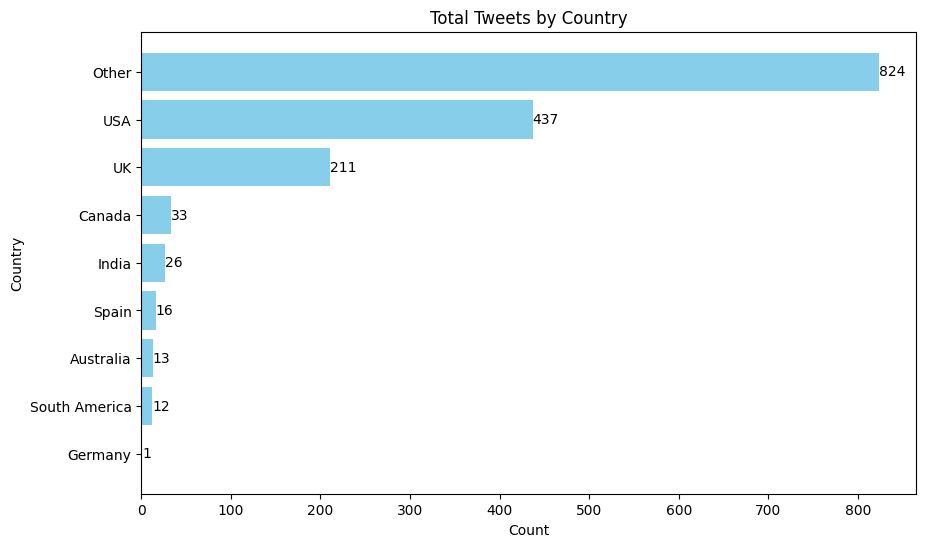

In [17]:
# Sort the dictionary by values in descending order
sorted_counts = dict(sorted(combined_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the data
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_counts.keys()), list(sorted_counts.values()), color='skyblue')
plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Total Tweets by Country')
plt.gca().invert_yaxis()  # Invert y-axis to display highest count at the top
for i, v in enumerate(list(sorted_counts.values())):
    plt.text(v, i, str(v), ha='left', va='center')
plt.show()

Here we see that other(824) has blend of different miscelleanous tweets from various locations. But the highest are from USA, 2nd highest from UK.

#### Non-aplha numeric locations

In [18]:
non_alpha_locations = df[df['location'].str.contains(r'[^a-zA-Z,\s]', na=False)]

# Print the resulting DataFrame containing locations with non-alphabetic characters
non_aplha_location_dict = non_alpha_locations.location.value_counts().to_dict()
print('The no. of non alpha numeric locations are: ', len(non_aplha_location_dict))
#non_aplha_location_dict

The no. of non alpha numeric locations are:  128


## Sentiment analysis of tweets:

In [19]:
def get_sentiment_score(text):
    # Create a TextBlob object
    blob = TextBlob(text)
    # Get the sentiment polarity
    polarity = blob.sentiment.polarity
    return polarity

# Function to get sentiment polarity
def get_sentiment(polarity):
    # # Create a TextBlob object
    # blob = TextBlob(text)
    # # Get the sentiment polarity
    # polarity = blob.sentiment.polarity
    # Classify sentiment as positive, negative, or neutral based on polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to the 'text' column to get sentiment for each text
df['sentiment_score'] = df['tweet_cleaned_new'].apply(get_sentiment_score)
df['sentiment'] = df['sentiment_score'].apply(get_sentiment)

# Print the DataFrame with sentiment column
df.head()

,author_id,statuses_count,location,verified,followers_count,friends_count,listed_count,tweets_or_status_favorited_count,tweet_id,text,created_at,lang,retweet_count,hashtags,favorite_count,tweet_cleaned_new,sentiment_score,sentiment
0,1552675995081183233,271,méxico/cdmx,False,118,45,0,1336,1628907212088176644,"I said before i was kind of a weeb.\nSo here, ...",2023-02-23 23:58:37,en,28,"[{'text': 'save101dalmatianstreet', 'indices':...",95,said kind weeb take save101dalmatianstreet 101...,0.150000,Positive
1,723532208179404800,56702,"london, england",False,765,2383,10,6600,1628906869048713216,#Extraordinary is an absolute must-see #TVShow...,2023-02-23 23:57:15,en,0,"[{'text': 'Extraordinary', 'indices': [0, 14]}...",0,extraordinary absolute must see tvshow perfect...,0.480556,Positive
2,723532208179404800,56702,"london, england",False,765,2383,10,6600,1628906599266779136,Why You Should Watch: #Atlanta #FX #DisneyPlus...,2023-02-23 23:56:11,en,0,"[{'text': 'Atlanta', 'indices': [22, 30]}, {'t...",0,watch atlanta fx disneyplus tv https co jkscuz...,0.000000,Neutral
3,1613354669161566208,701,NaN,False,60,203,0,3428,1628906485752254464,#selfiesforwillow plus I wanted to show off my...,2023-02-23 23:55:44,en,1,"[{'text': 'selfiesforwillow', 'indices': [0, 1...",11,selfiesforwillow plus wanted show new sweater ...,-0.231818,Negative
4,723532208179404800,56702,"london, england",False,765,2383,10,6600,1628906112803020800,#TheWalkingDeadUK: #TheWalkingDead 1124 'Rest ...,2023-02-23 23:54:15,en,0,"[{'text': 'TheWalkingDeadUK', 'indices': [0, 1...",0,thewalkingdeaduk thewalkingdead 1124 rest peac...,0.000000,Neutral


In [20]:
positive_tweets = len(df[df.sentiment == 'Positive'])
negative_tweets = len(df[df.sentiment == 'Negative'])
neutral_tweets = len(df[df.sentiment == 'Neutral'])
print(f'Positive tweets: {positive_tweets}, Negative Tweets: {negative_tweets}, Neutral Tweets: {neutral_tweets}')

Positive tweets: 1121, Negative Tweets: 255, Neutral Tweets: 1169


In [21]:
df['date'] = df['created_at'].dt.date
df.head(2)

,author_id,statuses_count,location,verified,followers_count,friends_count,listed_count,tweets_or_status_favorited_count,tweet_id,text,created_at,lang,retweet_count,hashtags,favorite_count,tweet_cleaned_new,sentiment_score,sentiment,date
0,1552675995081183233,271,méxico/cdmx,False,118,45,0,1336,1628907212088176644,"I said before i was kind of a weeb.\nSo here, ...",2023-02-23 23:58:37,en,28,"[{'text': 'save101dalmatianstreet', 'indices':...",95,said kind weeb take save101dalmatianstreet 101...,0.150000,Positive,2023-02-23
1,723532208179404800,56702,"london, england",False,765,2383,10,6600,1628906869048713216,#Extraordinary is an absolute must-see #TVShow...,2023-02-23 23:57:15,en,0,"[{'text': 'Extraordinary', 'indices': [0, 14]}...",0,extraordinary absolute must see tvshow perfect...,0.480556,Positive,2023-02-23


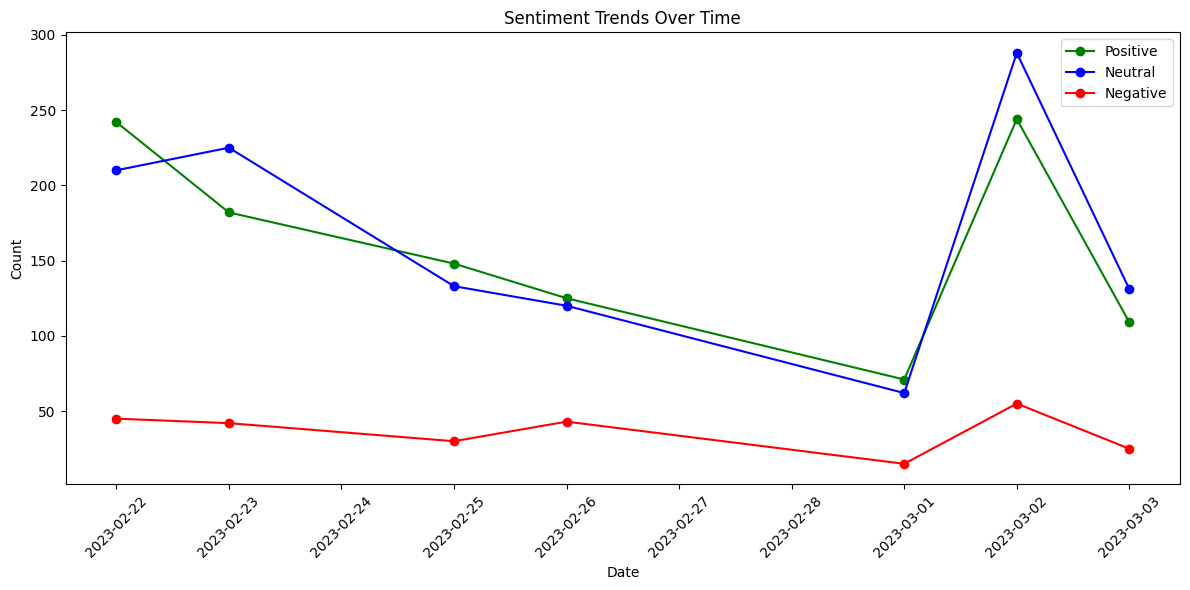

In [22]:
sentiment_over_time = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(sentiment_over_time.index, sentiment_over_time['Positive'], label='Positive', marker='o', color = 'green')
plt.plot(sentiment_over_time.index, sentiment_over_time['Neutral'], label='Neutral', marker='o', color = 'blue')
plt.plot(sentiment_over_time.index, sentiment_over_time['Negative'], label='Negative', marker='o', color = 'red')

plt.title('Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

Here, we see that the sentiment has overall stayed between positive and neutral for the brand which is a good thing.

# A. Tweets EDA

#### 1. No. of tweets per day

In [23]:
tweet_timeline = df.groupby(df['created_at'].dt.date).size()
tweets_per_day = df['date'].value_counts().sort_index()

print(tweets_per_day)

date
2023-02-22    497
2023-02-23    449
2023-02-25    311
2023-02-26    288
2023-03-01    148
2023-03-02    587
2023-03-03    265
Name: count, dtype: int64


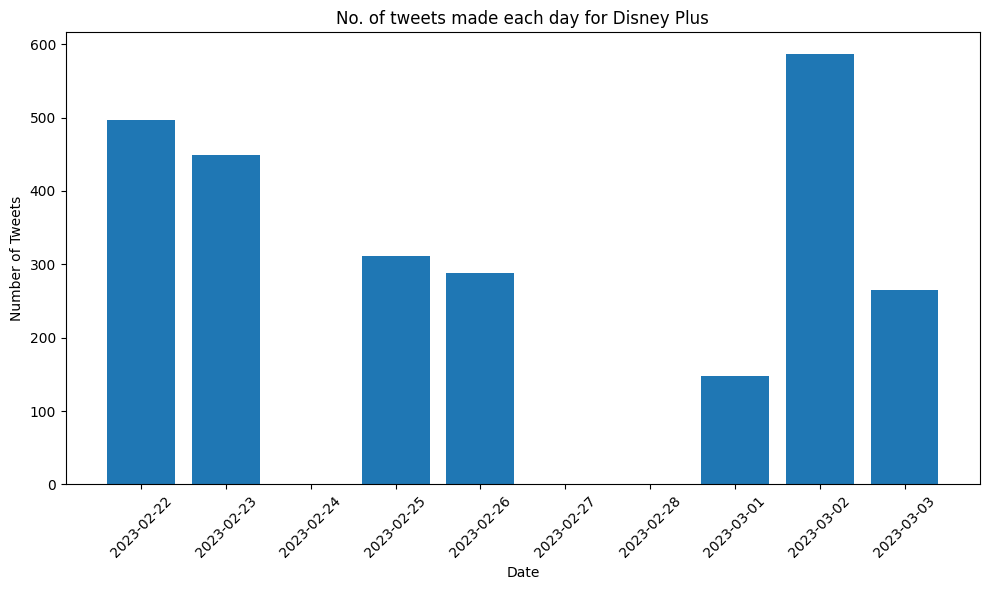

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(tweet_timeline.index, tweet_timeline.values)
plt.title('No. of tweets made each day for Disney Plus')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 2. No. of unique users:

In [25]:
df.author_id.nunique()

1073

There are 1073 unique users among 2545 tweets available.

#### 3. No. of verified and not verified users:

In [26]:
# Filter the DataFrame to include only verified users
verified_users_df = df[df['verified'] == True]
not_verified_users_df = df[df['verified'] == False]

# Count the number of unique verified and not verified users
print('No. of verified users is: ',len(verified_users_df['author_id'].unique()))
print('No. of not verified users is: ',len(not_verified_users_df['author_id'].unique()))

No. of verified users is:  40
No. of not verified users is:  1033


#### Analysing verified users:

In [27]:
tweets_by_verified_users = verified_users_df.groupby('author_id').size()

# Print the result
print("Number of tweets by verified users individually:")
print(tweets_by_verified_users)

Number of tweets by verified users individually:
author_id
821193                  1
15066876                1
15375209                1
16319706                1
16541021                1
17497090                2
18623463                1
18682378                1
18847632                1
19383317                1
21113724                5
22053827                1
25140900                1
25407190                1
26411479                2
26553240                1
32995539                1
34396109                1
36008477               16
36251026               11
128824869               1
135688569               1
226835223               2
488231779               1
500083989               4
532332926               1
1173464773              8
1647350138              1
2458136202              1
828841083257778176      1
848997614095814656      1
906213869042917377      1
985916593065476096     25
1010217640139227136     1
1011345105645592576     1
1011377593344393217    14
10990

Thus we can see that verified users aren't tweeting much about the brand.

#### 4. Top users by count and their location:

In [28]:
# Group by author_id and count the number of tweets
tweets_by_users = df.groupby('author_id').size()
top_10_users = tweets_by_users.nlargest(10)

# Create a DataFrame with author_id and tweet counts
top_users_df = pd.DataFrame({'author_id': top_10_users.index, 'tweet_count': top_10_users.values})

# Merge the DataFrame with the original DataFrame to get locations
top_users_with_location = pd.merge(top_users_df, df[['author_id', 'location', 'verified']], on='author_id', how='left').drop_duplicates()

# Print the result
print("Top 10 people with the highest number of tweets and their locations:")
print(top_users_with_location)

Top 10 people with the highest number of tweets and their locations:
               author_id  tweet_count              location  verified
0    1534870262679748609          126       los angeles, ca     False
126  1590931714024607745           87              internet     False
213  1060664640122863616           75                   NaN     False
288  1081157956098351104           70                   NaN     False
358            218812313           61                    uk     False
419  1597224114196217857           52                   NaN     False
471           3134622627           39  location: classified     False
510            281961720           38                   NaN     False
548  1584089739476766721           38                   NaN     False
586   723532208179404800           36       london, england     False


#### 5. Analyzing top 10 influential tweets based on no. of retweets and favourites

a. **Top 10 influential tweets based on no. of retweets and favourites**

In [29]:
# Assuming df_new is your DataFrame containing the relevant columns
# Calculate the weighted score
df['influence_score_retweet_fav'] = df['retweet_count'] + df['favorite_count']

# Sort the DataFrame by influence score in descending order
df_sorted = df.sort_values(by='influence_score_retweet_fav', ascending=False)

# Select the top 5 influencers
top_10_influential_tweets = df_sorted.head(10)

# Print the top 5 influencers
print("Top 10 influential tweets:")
#print(top_5_influencers[['author_id', 'followers_count', 'retweet_count', 'favorite_count']])
top_10_influential_tweets.head(10)

Top 10 influential tweets:


,author_id,statuses_count,location,verified,followers_count,friends_count,listed_count,tweets_or_status_favorited_count,tweet_id,text,created_at,lang,retweet_count,hashtags,favorite_count,tweet_cleaned_new,sentiment_score,sentiment,date,influence_score_retweet_fav
991,985916593065476096,42477,worldwide,True,5215336,266,6611,3012,1629934324035518464,"Only 🫰🫰🫰 for #jhope.\n\nj-hope IN THE BOX, a d...",2023-02-26 20:00:00,en,13539,"[{'text': 'jhope', 'indices': [13, 19]}, {'tex...",35065,jhope j hope box documentary special streaming...,0.178571,Positive,2023-02-26,48604
538,1488626051194490881,1482,knowhere,False,110059,301,230,3210,1628497510477049859,"#Echo, #Ironheart and #AgathaCovenOfChaos will...",2023-02-22 20:50:37,en,736,"[{'text': 'Echo', 'indices': [0, 5]}, {'text':...",7991,echo ironheart agathacovenofchaos series come ...,0.000000,Neutral,2023-02-22,8727
2116,4019049327,2344,chester uk,False,3814,295,26,4288,1631276547263934464,"Grogu's spinning chair, from the Mandalorian s...",2023-03-02 12:53:31,en,750,"[{'text': 'LEGO', 'indices': [66, 71]}, {'text...",6330,grogu spinning chair mandalorian season 3 epis...,0.000000,Neutral,2023-03-02,7080
45,1488626051194490881,1482,knowhere,False,110059,301,230,3210,1628865783248871426,#VisionQuest will have more than six episodes\...,2023-02-23 21:14:00,en,445,"[{'text': 'VisionQuest', 'indices': [0, 12]}, ...",6255,visionquest six episodes marvelstudios disneyp...,0.000000,Neutral,2023-02-23,6700
103,18847632,3949,"dublin, ire",True,1649547,40,4950,41,1628835642561155072,Let’s take it from the top. Stream Bono &amp; ...,2023-02-23 19:14:14,en,835,"[{'text': 'DisneyPlus', 'indices': [143, 154]}]",5368,let take top stream bono amp edge sort homecom...,0.308036,Positive,2023-02-23,6203
2538,985916593065476096,42477,worldwide,True,5215338,266,6611,3012,1631023587414126592,Don’t miss the return of #TheMandalorian. \n\n...,2023-03-01 20:08:20,en,328,"[{'text': 'TheMandalorian', 'indices': [25, 40...",2662,miss return themandalorian chapter 17 streamin...,0.000000,Neutral,2023-03-01,2990
735,985916593065476096,42477,worldwide,True,5215335,266,6611,3012,1628395406605565953,New character posters for #TheMandalorian and ...,2023-02-22 14:04:53,en,255,"[{'text': 'TheMandalorian', 'indices': [26, 41...",1934,new character posters themandalorian grogu bok...,0.136364,Positive,2023-02-22,2189
136,25140900,7817,new york city,True,387789,93,3927,156,1628817769390276609,Let’s take it from the top.\nStream Bono &amp;...,2023-02-23 18:03:12,en,245,"[{'text': 'DisneyPlus', 'indices': [143, 154]}]",1579,let take top stream bono amp edge sort homecom...,0.308036,Positive,2023-02-23,1824
1257,985916593065476096,42477,worldwide,True,5215338,266,6611,3012,1629602143438086144,Easily the most versatile of kitchen cookware....,2023-02-25 22:00:02,en,91,"[{'text': 'Tangled', 'indices': [68, 76]}, {'t...",1395,easily versatile kitchen cookware k c undercov...,0.433333,Positive,2023-02-25,1486
1303,985916593065476096,42477,worldwide,True,5215338,266,6611,3012,1629541741383626752,“There’s something dangerous happening out the...,2023-02-25 18:00:01,en,142,"[{'text': 'TheMandalorian', 'indices': [71, 86...",1206,something dangerous happening new season thema...,-0.231818,Negative,2023-02-25,1348


b. **Sentiment Analysis of Influential Tweets Over Time**

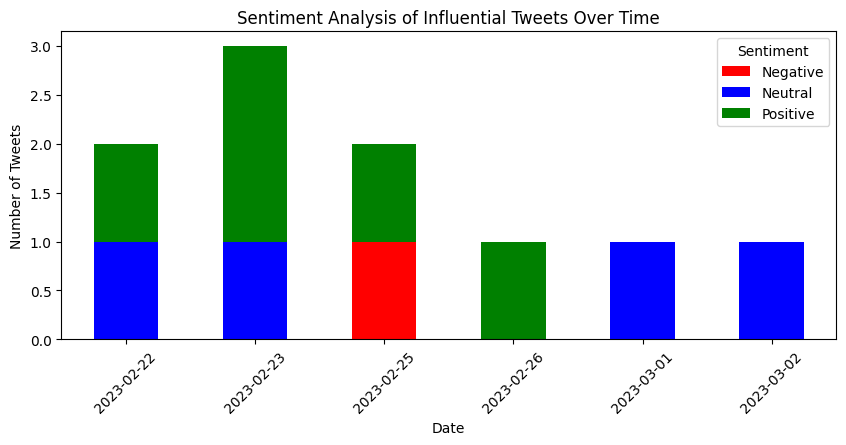

In [30]:
sentiment_of_influential_tweets = top_10_influential_tweets.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

colors = ['red','blue', 'green', ]

sentiment_of_influential_tweets.plot(kind='bar', stacked=True, figsize=(10, 4), color = colors)
plt.title('Sentiment Analysis of Influential Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

We can see that the top 10 influential tweets throughout those days are positive or neutral showcasing a positive brand image

In [31]:
top_10_influential_tweets.author_id.value_counts()

author_id
985916593065476096     5
1488626051194490881    2
4019049327             1
18847632               1
25140900               1
Name: count, dtype: int64

This shows that author- 985916593065476096 has highest no. of influential tweets posted among others

#### 6. Most popular tweet on each active day

In [32]:
max_date = df['created_at'].max()
min_date = df['created_at'].min()

print("Maximum tweet created_at date:", max_date)
print("Minimum tweet created_at date:", min_date)

Maximum tweet created_at date: 2023-03-03 15:37:32
Minimum tweet created_at date: 2023-02-22 00:01:26


In [33]:
tweets_by_date = df.groupby('date')

# Initialize an empty list to store the maximum influence tweets for each day
max_influence_tweets = []

# Iterate over groups
for date, group in tweets_by_date:
    # Find the tweet with the maximum 'influence_score_retweet_fav' for the current day
    max_influence_tweet = group.loc[group['influence_score_retweet_fav'].idxmax()]
    max_influence_tweets.append(max_influence_tweet)

# Create a DataFrame from the list of maximum influence tweets
df_max_influence_tweets = pd.DataFrame(max_influence_tweets)

# Display the DataFrame
df_max_influence_tweets[['date', 'author_id','tweet_id', 'text','sentiment']]

,date,author_id,tweet_id,text,sentiment
538,2023-02-22,1488626051194490881,1628497510477049859,"#Echo, #Ironheart and #AgathaCovenOfChaos will...",Neutral
45,2023-02-23,1488626051194490881,1628865783248871426,#VisionQuest will have more than six episodes\...,Neutral
1257,2023-02-25,985916593065476096,1629602143438086144,Easily the most versatile of kitchen cookware....,Positive
991,2023-02-26,985916593065476096,1629934324035518464,"Only 🫰🫰🫰 for #jhope.\n\nj-hope IN THE BOX, a d...",Positive
2538,2023-03-01,985916593065476096,1631023587414126592,Don’t miss the return of #TheMandalorian. \n\n...,Neutral
2116,2023-03-02,4019049327,1631276547263934464,"Grogu's spinning chair, from the Mandalorian s...",Neutral
1590,2023-03-03,985916593065476096,1631655666527133701,This is the Way… to the weekend. 🙌\n\nStream t...,Positive


#### 7. Tweets and hashtags:

a. **Counting hashtags per tweet:**

In [34]:
def count_hashtags(hashtags_data):
    hashtag_list = ast.literal_eval(hashtags_data)
    return len(hashtag_list)

# Apply the function to each row of the DataFrame and create a new column 'count_hashtags'
df['count_hashtags'] = df['hashtags'].apply(lambda x: count_hashtags(x))

# Print the updated DataFrame
df.head()

,author_id,statuses_count,location,verified,followers_count,friends_count,listed_count,tweets_or_status_favorited_count,tweet_id,text,...,lang,retweet_count,hashtags,favorite_count,tweet_cleaned_new,sentiment_score,sentiment,date,influence_score_retweet_fav,count_hashtags
0,1552675995081183233,271,méxico/cdmx,False,118,45,0,1336,1628907212088176644,"I said before i was kind of a weeb.\nSo here, ...",...,en,28,"[{'text': 'save101dalmatianstreet', 'indices':...",95,said kind weeb take save101dalmatianstreet 101...,0.150000,Positive,2023-02-23,123,7
1,723532208179404800,56702,"london, england",False,765,2383,10,6600,1628906869048713216,#Extraordinary is an absolute must-see #TVShow...,...,en,0,"[{'text': 'Extraordinary', 'indices': [0, 14]}...",0,extraordinary absolute must see tvshow perfect...,0.480556,Positive,2023-02-23,0,6
2,723532208179404800,56702,"london, england",False,765,2383,10,6600,1628906599266779136,Why You Should Watch: #Atlanta #FX #DisneyPlus...,...,en,0,"[{'text': 'Atlanta', 'indices': [22, 30]}, {'t...",0,watch atlanta fx disneyplus tv https co jkscuz...,0.000000,Neutral,2023-02-23,0,4
3,1613354669161566208,701,NaN,False,60,203,0,3428,1628906485752254464,#selfiesforwillow plus I wanted to show off my...,...,en,1,"[{'text': 'selfiesforwillow', 'indices': [0, 1...",11,selfiesforwillow plus wanted show new sweater ...,-0.231818,Negative,2023-02-23,12,3
4,723532208179404800,56702,"london, england",False,765,2383,10,6600,1628906112803020800,#TheWalkingDeadUK: #TheWalkingDead 1124 'Rest ...,...,en,0,"[{'text': 'TheWalkingDeadUK', 'indices': [0, 1...",0,thewalkingdeaduk thewalkingdead 1124 rest peac...,0.000000,Neutral,2023-02-23,0,6


b. **Tweets with max hashtags:**

In [35]:
# Find the row with the maximum count_hashtags value
max_hashtags_tweet = df.nlargest(3, 'count_hashtags')

# Print the result
print("Top 3 Tweets with the maximum count of hashtags:")
max_hashtags_tweet

Top 3 Tweets with the maximum count of hashtags:


,author_id,statuses_count,location,verified,followers_count,friends_count,listed_count,tweets_or_status_favorited_count,tweet_id,text,...,lang,retweet_count,hashtags,favorite_count,tweet_cleaned_new,sentiment_score,sentiment,date,influence_score_retweet_fav,count_hashtags
764,1621347917993738242,6,NaN,False,0,1,0,1,1628375348239818757,Whispers 2: Encanto ✨\n\n#encanto #disney #dis...,...,en,1,"[{'text': 'encanto', 'indices': [23, 31]}, {'t...",1,whispers 2 encanto encanto disney disneyplus s...,0.159091,Positive,2023-02-22,2,28
1225,1216092783246741505,18213,"liverpool, united kingdom",False,5841,5624,16,109811,1629638877542510592,X-Men :D #Shorts #YouTubeShorts #XMen #XMen97 ...,...,en,0,"[{'text': 'Shorts', 'indices': [9, 16]}, {'tex...",0,x men shorts youtubeshorts xmen xmen97 thedail...,0.166667,Positive,2023-02-26,0,26
432,1216092783246741505,18213,"liverpool, united kingdom",False,5841,5624,16,109811,1628554977642786816,Spiderman :D #Shorts #YouTubeShorts #Spiderman...,...,en,0,"[{'text': 'Shorts', 'indices': [13, 20]}, {'te...",0,spiderman shorts youtubeshorts spiderman spide...,0.166667,Positive,2023-02-23,0,25


c. **Most tweeted hashtags**

In [36]:
from itertools import chain

def get_hashtag_text(hashtags):
    hashtags_text = []
    for i in hashtags:
        hashtags_data = ast.literal_eval(i)

        # Extract the 'text' key from each dictionary in the list
        hashtags_text.append([data['text'] for data in hashtags_data])
    return list(chain(*hashtags_text))
        
#data_tags = df_new.head(5)
hashtags_list = get_hashtag_text(df.hashtags)
#print(hashtags_list)

In [37]:
from collections import Counter
# Count occurrences of each hashtag
hashtags_count = Counter(hashtags_list)
# dictionary from Counter object
hashtags_dict = dict(hashtags_count)

# Find the 5 most common hashtags
top_10_hashtags = hashtags_count.most_common(10)

print("Top 10 most popular hashtags:")
for hashtag, count in top_10_hashtags:
    print(f"#{hashtag}: {count} times")

Top 10 most popular hashtags:
#DisneyPlus: 1959 times
#disneyplus: 432 times
#TheMandalorian: 415 times
#StarWars: 359 times
#Disney: 329 times
#Netflix: 199 times
#Movies: 153 times
#Grogu: 153 times
#Streaming: 150 times
#Disneyplus: 149 times


In [38]:
print('Unique hashtags used are: ',len(hashtags_dict))

Unique hashtags used are:  2922


Therefore we see #DisneyPlus (most tweeted hashtag), #disneyplus, #TheMandalorian, #StarWars, #Disney, #Netflix etc. are among the top hashtags used most.

d. **Comparative Analysis between Hashtag Count, Retweets, and Favorite Count:**

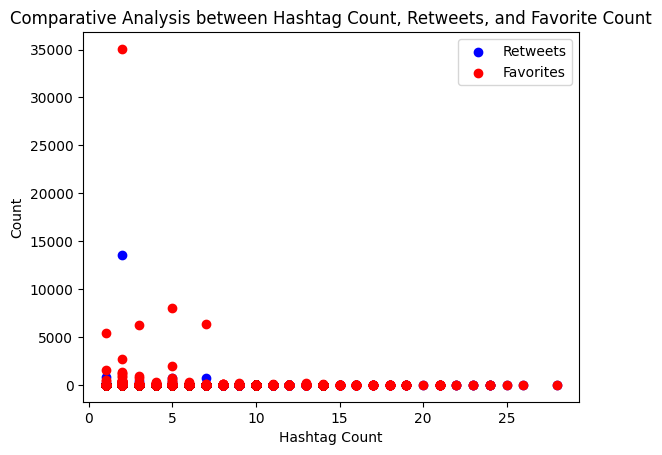

In [39]:
# Plotting hashtag_count vs retweet_count
plt.scatter(df['count_hashtags'], df['retweet_count'], color='blue', label='Retweets')

# Plotting hashtag_count vs favorite_count
plt.scatter(df['count_hashtags'], df['favorite_count'], color='red', label='Favorites')

# Adding labels and title
plt.xlabel('Hashtag Count')
plt.ylabel('Count')
plt.title('Comparative Analysis between Hashtag Count, Retweets, and Favorite Count')
plt.legend()

# Displaying the plot
plt.show()

Its clear that with increasing number of hashtags, the number of favourites and retweet count is decreasing.

#### 8. Top tweet by favourites and retweets

a. **Most Favourited tweet**

In [40]:
# Find the row with the maximum count_hashtags value
max_favourite_tweet = df.nlargest(1, 'favorite_count')

# Print the result
print("Tweet with the maximum count of favourite:")
max_favourite_tweet

Tweet with the maximum count of favourite:


,author_id,statuses_count,location,verified,followers_count,friends_count,listed_count,tweets_or_status_favorited_count,tweet_id,text,...,lang,retweet_count,hashtags,favorite_count,tweet_cleaned_new,sentiment_score,sentiment,date,influence_score_retweet_fav,count_hashtags
991,985916593065476096,42477,worldwide,True,5215336,266,6611,3012,1629934324035518464,"Only 🫰🫰🫰 for #jhope.\n\nj-hope IN THE BOX, a d...",...,en,13539,"[{'text': 'jhope', 'indices': [13, 19]}, {'tex...",35065,jhope j hope box documentary special streaming...,0.178571,Positive,2023-02-26,48604,2


b. **Most retweeted tweet**

In [41]:
# Find the row with the maximum count_hashtags value
max_retweet_tweet = df.nlargest(1, 'retweet_count')

# Print the result
print("Tweet with the maximum count of retweets:")
max_retweet_tweet

Tweet with the maximum count of retweets:


,author_id,statuses_count,location,verified,followers_count,friends_count,listed_count,tweets_or_status_favorited_count,tweet_id,text,...,lang,retweet_count,hashtags,favorite_count,tweet_cleaned_new,sentiment_score,sentiment,date,influence_score_retweet_fav,count_hashtags
991,985916593065476096,42477,worldwide,True,5215336,266,6611,3012,1629934324035518464,"Only 🫰🫰🫰 for #jhope.\n\nj-hope IN THE BOX, a d...",...,en,13539,"[{'text': 'jhope', 'indices': [13, 19]}, {'tex...",35065,jhope j hope box documentary special streaming...,0.178571,Positive,2023-02-26,48604,2


Most favourite and retweeted tweet talks about Jhope, a member from the most famous Kpop band BTS

#### 9. Most followed user

In [42]:
# Find the row with the maximum count_hashtags value
most_followed_user = df.nlargest(1, 'followers_count')

# Print the result
print("Most followed user:")
most_followed_user

Most followed user:


,author_id,statuses_count,location,verified,followers_count,friends_count,listed_count,tweets_or_status_favorited_count,tweet_id,text,...,lang,retweet_count,hashtags,favorite_count,tweet_cleaned_new,sentiment_score,sentiment,date,influence_score_retweet_fav,count_hashtags
1257,985916593065476096,42477,worldwide,True,5215338,266,6611,3012,1629602143438086144,Easily the most versatile of kitchen cookware....,...,en,91,"[{'text': 'Tangled', 'indices': [68, 76]}, {'t...",1395,easily versatile kitchen cookware k c undercov...,0.433333,Positive,2023-02-25,1486,2


#### 10. User with max friends

In [43]:
# Find the row with the maximum count_hashtags value
top_3_users_with_max_friends = df.nlargest(3, 'friends_count')

# Print the result
print("Top 3 Twitter users with the maximum friends count:")
top_3_users_with_max_friends

Top 3 Twitter users with the maximum friends count:


,author_id,statuses_count,location,verified,followers_count,friends_count,listed_count,tweets_or_status_favorited_count,tweet_id,text,...,lang,retweet_count,hashtags,favorite_count,tweet_cleaned_new,sentiment_score,sentiment,date,influence_score_retweet_fav,count_hashtags
1079,35203319,1124971,"boston, ma",False,341242,310441,12981,587003,1629847725716979713,👀 📲 #Smartphone screen sizes just keep getting...,...,en,5,"[{'text': 'Smartphone', 'indices': [4, 15]}, {...",13,smartphone screen sizes keep getting bigger on...,0.166667,Positive,2023-02-26,18,9
1234,15066876,48145,global & north america,True,258226,126047,5143,12635,1629632143742705665,#Smartphone screen sizes just keep getting big...,...,en,4,"[{'text': 'Smartphone', 'indices': [0, 11]}, {...",7,smartphone screen sizes keep getting bigger on...,0.166667,Positive,2023-02-25,11,9
1222,15791117,59084,"colorado springs, co",False,36373,35127,695,7272,1629644317777174528,Free Printable MULAN Activity Pack #Mulan #Dis...,...,en,0,"[{'text': 'Mulan', 'indices': [35, 41]}, {'tex...",1,free printable mulan activity pack mulan disne...,0.400000,Positive,2023-02-26,1,9


#### 11. Tweets promoting the brand

In [44]:
# Count tweets containing '@Disneyplus' or '@disneyplus'
tweets_with_disneyplus = df[df['text'].str.contains('@Disneyplus|@disneyplus|@DisneyPlus', case=False)]

# Get the count of tweets containing '@Disneyplus' or '@disneyplus'
len(tweets_with_disneyplus)

184

# B. Topic Modelling

## Performed Topic modelling using:

### **1. KMeans & TF-IDF**

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Step 2: Tokenization and Vectorization
def kmeans_topic_modelling(corpus_kmeans):
    # Step 2: Tokenization and Vectorization
    stop_words = ['http', 'co', 'disney', 'disneyplus']  # Specify the words to remove
    vectorizer = TfidfVectorizer(lowercase=True, max_features=100, max_df=0.8, min_df=2, ngram_range=(1, 2), stop_words=stop_words)
    vectors = vectorizer.fit_transform(corpus_kmeans)
    
    # Step 3: Apply KMeans with KMeans++ initialization
    model = KMeans(n_clusters = 3, init= 'k-means++',n_init=1, random_state=42)
    
    model.fit(vectors)
    
    # Get the centroids
    centroids = model.cluster_centers_
    
    # Sort the centroids indices
    order_centroids = centroids.argsort()[:, ::-1]
    
    # Get the feature names
    terms = vectorizer.get_feature_names_out()
    for i in range(3):
        print(f"Topic {i}:")
        top_terms = [terms[ind] for ind in order_centroids[i, :10]]
        print(top_terms)

kmeans_topic_modelling(df['tweet_cleaned_new'])

Topic 0:
['marvel', 'movie', 'amp', 'plus', 'series', 'marvelstudios', 'streaming', 'trailer', 'animation', 'new']
Topic 1:
['themandalorian', 'starwars', 'mandalorian', 'grogu', 'season', 'starwars https', 'themandalorian starwars', 'new', 'pedropascal', 'thisistheway']
Topic 2:
['news', 'prime hulu', 'fun netflix', 'hulu trailers', 'culture fun', 'movies music', 'music celebrities', 'netflix prime', 'trailers streaming', 'spotify podcasts']


### **2. NFM & TF-IDF**

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


def nfm_topic_modelling(corpus_nfm):
    # Step 2: Tokenization and Vectorization
    stop_words = ['http', 'co', 'disney', 'disneyplus']  # Specify the words to remove
    tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=6, stop_words=stop_words ,max_features = 100,)
    tfidf = tfidf_vectorizer.fit_transform(corpus_nfm)
    
    # Step 3: Apply NMF
    num_topics = 3  # Specify the number of topics
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_model.fit(tfidf)
    
    # Step 4: Interpret the Topics
    feature_names = tfidf_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topic {topic_idx}:", ", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

nfm_topic_modelling(df['tweet_cleaned_new'])

Topic 0: themandalorian, starwars, mandalorian, grogu, season, new, pedropascal, episode, thisistheway, mando
Topic 1: streaming, hulu, netflix, movies, news, podcasts, music, prime, trailers, spotify
Topic 2: 30, day, hotstar, disneyplushotstarth, 99, viupremium, iqiyidiamond, 65, days, acc


### **3. LDA**

In [47]:
stopword = ['http', 'co', 'disney', 'disneyplus']  # Specify the words to remove
def preprocess_tweets(customer):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for tweets in customer['tweet_cleaned_new']:
        words = [w for w in word_tokenize(tweets) if (w not in stopword)]

        words = [lem.lemmatize(w) for w in words if len(w) > 2]

        corpus.append(words)
    return corpus

def lda_topic_modelling(df):
    corpus_lda = preprocess_tweets(df)
    # Creating bag of words model using gensim
    dic = gensim.corpora.Dictionary(corpus_lda)

    # Filter out the word "http" from the dictionary
    http_id = dic.token2id.get("http", None)
    if http_id is not None:
        dic.filter_tokens(bad_ids=[http_id])
    
    bow_corpus = [dic.doc2bow(doc) for doc in corpus_lda]
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                                    id2word=dic,
                                                    num_topics=3,
                                                    random_state=10,
                                                    update_every=1,
                                                    chunksize=200,
                                                    passes=5,
                                                    alpha='auto',
                                                    iterations=100,
                                                    per_word_topics=True)
    
    # Print topics
    for idx, topic in lda_model.print_topics(-1):
        words = topic.split("+")
        word_list = [word.split("*")[1].strip().strip('"') for word in words]
        print(f"Topic {idx}:")
        print(", ".join(word_list))

In [48]:
lda_topic_modelling(df)

Topic 0:
marvel, day, hotstar, disneyplushotstarth, peter, pan, peterpanandwendy, marvelstudios, animation, acc
Topic 1:
trailer, movie, hulu, news, streaming, netflix, music, fun, culture, podcasts
Topic 2:
themandalorian, starwars, mandalorian, season, grogu, episode, new, watch, mando, amp


In [49]:
def get_lda_visualization(df):
    corpus_lda = preprocess_tweets(df)
    # Creating bag of words model using gensim
    dic = gensim.corpora.Dictionary(corpus_lda)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus_lda]
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                                    id2word=dic,
                                                    num_topics=3,
                                                    random_state=42,
                                                    update_every=1,
                                                    chunksize=200,
                                                    passes=5,
                                                    alpha='auto',
                                                    iterations=100,
                                                    per_word_topics=True)
    return lda_model, bow_corpus, dic

In [50]:
lda_model_bow_corpus = get_lda_visualization(df)
vis = pyLDAvis.gensim_models.prepare(lda_model_bow_corpus[0], lda_model_bow_corpus[1], lda_model_bow_corpus[2])
pyLDAvis.save_html(vis, 'LDA_Visualization.html')

### Word cloud Generation

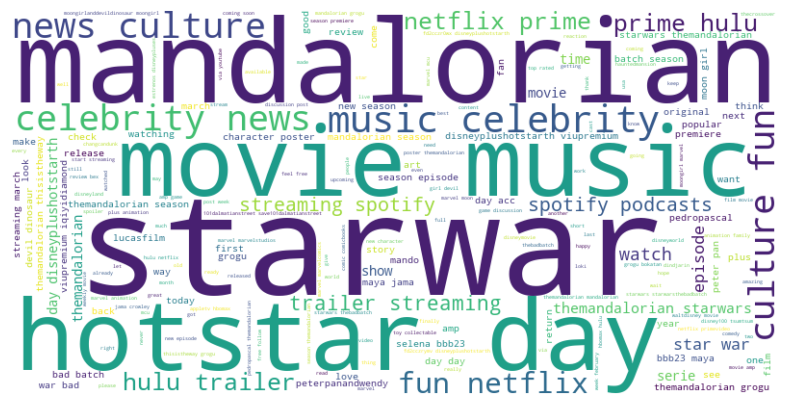

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def remove_specific_words(corpus, words_to_remove):
    filtered_corpus = []
    for document in corpus:
        filtered_document = [word for word in document if word not in words_to_remove]
        filtered_corpus.append(filtered_document)
    return filtered_corpus

def generate_wordCloud(corpus_lda):
    words_to_remove = ['https', 'co']
        
    # Assuming `influencer_corpus` is a list of lists of words representing your text data
    corpus_lda = remove_specific_words(corpus_lda, words_to_remove)
    
    # Flatten the list of lists into a single list of words
    flat_corpus_lda = [word for sublist in corpus_lda for word in sublist]
    
    # Combine all text into a single string
    text = ' '.join(flat_corpus_lda)
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(text)
    
    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

corpus_lda = preprocess_tweets(df)
generate_wordCloud(corpus_lda)

# As per information available online, There were 6 major releases between of 15th feb and 3rd March, 2023:
#### 1. Marvel’s Moon Girl and Devil Dinosaur – 15th Feb
#### 2. jhope IN THE BOX - 17th Feb
#### 3. The Proud Family: Louder and Prouder – 23rd Feb
#### 4. Voices Rising: The Music of Wakanda Forever – 28th Feb
#### 5. The Mandalorian season 3 – 1st March
#### 6. Peter Pan and Wendy movie trailer released - 1st March

In [52]:
# Create a boolean mask for tweets containing 'black panther' or 'wakanda'
mask1 = df['tweet_cleaned_new'].str.contains('moon girl|devil dinosaur|dinosaur|lunella|moongirl', case=False)

# Use the boolean mask to select rows from the DataFrame
df_moon_girl = df[mask1].sort_values(by='date')
average_sentiment_moon_girl = df_moon_girl['sentiment_score'].mean()
# Print the selected tweets
unique_users = df_moon_girl.author_id.nunique()
print("No. of tweets made for Moon girl and Devil Dinosaur:", len(df_moon_girl))
print("No. of unique users tweeting about Moon girl and Devil Dinosaur:", unique_users)
print("Average Sentiment for this topic is: ", average_sentiment_moon_girl)

No. of tweets made for Moon girl and Devil Dinosaur: 53
No. of unique users tweeting about Moon girl and Devil Dinosaur: 25
Average Sentiment for this topic is:  0.12463729273870783


In [53]:
# Create a boolean mask for tweets containing 'black panther' or 'wakanda'
mask2 = df['tweet_cleaned_new'].str.contains('jhope', case=False)

# Use the boolean mask to select rows from the DataFrame
df_jhope = df[mask2].sort_values(by='date')
average_sentiment_jhope = df_jhope['sentiment_score'].mean()
# Print the selected tweets
unique_users = df_jhope.author_id.nunique()
print("No. of tweets made for jhope IN THE BOX:", len(df_jhope))
print("No. of unique users tweeting about jhope IN THE BOX:", unique_users)
print("Average Sentiment for this topic is: ", average_sentiment_jhope)

No. of tweets made for jhope IN THE BOX: 15
No. of unique users tweeting about jhope IN THE BOX: 15
Average Sentiment for this topic is:  0.284484607984608


In [54]:
# Create a boolean mask for tweets containing 'black panther' or 'wakanda'
mask3 = df['tweet_cleaned_new'].str.contains('proud family|proudfamily', case=False)

# Use the boolean mask to select rows from the DataFrame
df_proud_family = df[mask3].sort_values(by='date')
average_sentiment_family = df_proud_family['sentiment_score'].mean()
# Print the selected tweets
unique_users = df_proud_family.author_id.nunique()
print("No. of tweets made for The Proud Family:", len(df_proud_family))
print("No. of unique users tweeting about The Proud Family:", unique_users)
print("Average Sentiment for this topic is: ", average_sentiment_family)

No. of tweets made for The Proud Family: 10
No. of unique users tweeting about The Proud Family: 10
Average Sentiment for this topic is:  0.2993049242424243


In [55]:
# Create a boolean mask for tweets containing 'black panther' or 'wakanda'
mask4 = df['tweet_cleaned_new'].str.contains('panther|wakanda|black panther|blackpanther|voices rising', case=False)

# Use the boolean mask to select rows from the DataFrame
df_black_panther = df[mask4].sort_values(by='date')
average_sentiment_panther = df_black_panther['sentiment_score'].mean()
# Print the selected tweets
unique_users = df_black_panther.author_id.nunique()
print("No. of tweets made for Black Panther:", len(df_black_panther))
print("No. of unique users tweeting about Black Panther:", unique_users)
print("Average Sentiment for this topic is: ", average_sentiment_panther)

No. of tweets made for Black Panther: 36
No. of unique users tweeting about Black Panther: 23
Average Sentiment for this topic is:  0.09650105552883331


In [56]:
# Create a boolean mask for tweets containing 'black panther' or 'wakanda'
mask5 = df['tweet_cleaned_new'].str.contains('the mandalorian|mandalorian|star wars|grogu', case=False)

# Use the boolean mask to select rows from the DataFrame
df_madalorian = df[mask5].sort_values(by='date')
average_sentiment_manda = df_madalorian['sentiment_score'].mean()

# Print the selected tweets
unique_users = df_madalorian.author_id.nunique()
print("No. of tweets made for The Mandalorian:", len(df_madalorian))
print("No. of unique users tweeting about The Mandalorian:", unique_users)
print("Average Sentiment for this topic is: ", average_sentiment_manda)

No. of tweets made for The Mandalorian: 645
No. of unique users tweeting about The Mandalorian: 377
Average Sentiment for this topic is:  0.066279195810342


In [57]:
# Create a boolean mask for tweets containing 'black panther' or 'wakanda'
mask = df['tweet_cleaned_new'].str.contains('peter|peterpanandwendy', case=False)

# Use the boolean mask to select rows from the DataFrame
df_peter = df[mask].sort_values(by='date')
average_sentiment_peter = df_peter['sentiment_score'].mean()

# Print the selected tweets
unique_users = df_peter.author_id.nunique()
print("No. of tweets made for Peter Pan and Wendy:", len(df_peter))
print("No. of unique users tweeting about Peter Pan and Wendy:", unique_users)
print("Average Sentiment for this topic is: ", average_sentiment_peter)

No. of tweets made for Peter Pan and Wendy: 62
No. of unique users tweeting about Peter Pan and Wendy: 52
Average Sentiment for this topic is:  0.08925701426709491


Since, the average sentiment score for all the topics is positive, we can say that people have positive sentiment towards discussing them online.

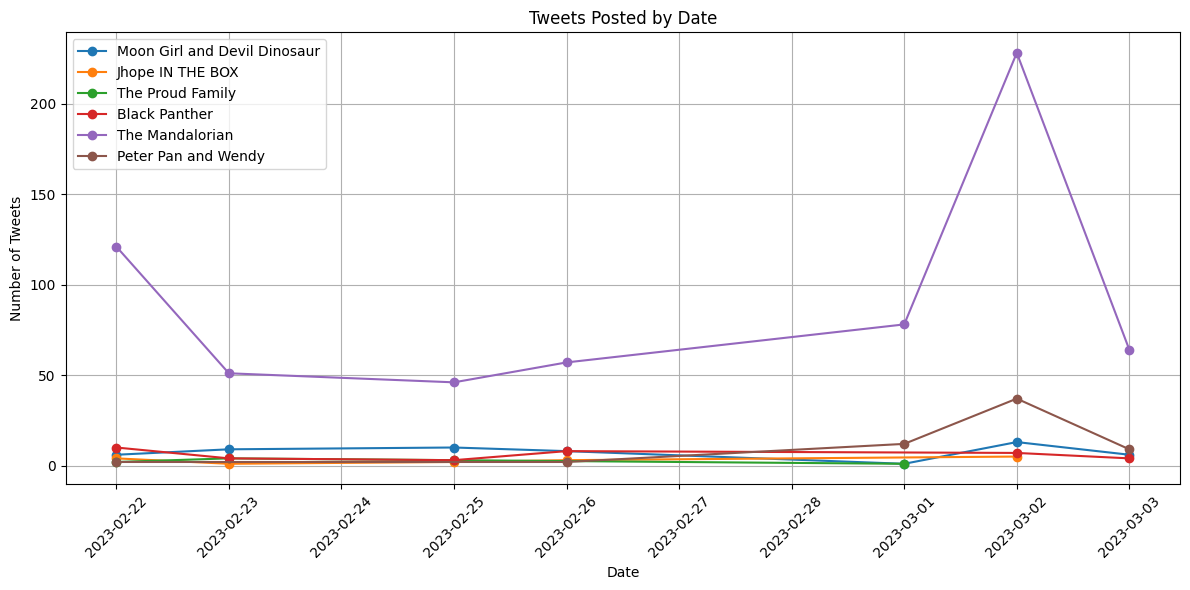

In [58]:
counts_peter_pan = df_peter.groupby('date').size()
counts_moon_girl = df_moon_girl.groupby('date').size()
counts_jhope = df_jhope.groupby('date').size()
counts_proud_family = df_proud_family.groupby('date').size()
counts_black_panther = df_black_panther.groupby('date').size()
counts_mandalorian = df_madalorian.groupby('date').size()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(counts_moon_girl.index, counts_moon_girl.values, label='Moon Girl and Devil Dinosaur', marker='o')
plt.plot(counts_jhope.index, counts_jhope.values, label='Jhope IN THE BOX', marker='o')
plt.plot(counts_proud_family.index, counts_proud_family.values, label='The Proud Family', marker='o')
plt.plot(counts_black_panther.index, counts_black_panther.values, label='Black Panther', marker='o')
plt.plot(counts_mandalorian.index, counts_mandalorian.values, label='The Mandalorian', marker='o')
plt.plot(counts_peter_pan.index, counts_peter_pan.values, label='Peter Pan and Wendy', marker='o')
plt.title('Tweets Posted by Date')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Topics discussed for different sentitment tweets

In [59]:
positive_tweets = df[df.sentiment == 'Positive']
negative_tweets = df[df.sentiment == 'Negative']
neutral_tweets = df[df.sentiment == 'Neutral']
print(f'Positive tweets: {len(positive_tweets)}, Negative Tweets: {len(negative_tweets)}, Neutral Tweets: {len(neutral_tweets)}')

Positive tweets: 1121, Negative Tweets: 255, Neutral Tweets: 1169


#### 1. For Positive tweets

In [60]:
kmeans_topic_modelling(positive_tweets['tweet_cleaned_new'])

Topic 0:
['amp', 'series', 'plus', 'original', 'marvel', 'love', 'movie', 'new', 'like', 'trailer']
Topic 1:
['themandalorian', 'starwars', 'new', 'mandalorian', 'season', 'grogu', 'starwars https', 'themandalorian starwars', 'episode', 'new season']
Topic 2:
['news', 'celebrities news', 'culture fun', 'prime hulu', 'celebrities', 'spotify podcasts', 'netflix prime', 'streaming spotify', 'movies music', 'music celebrities']


In [61]:
lda_topic_modelling(positive_tweets)

Topic 0:
new, peter, pan, peterpanandwendy, movie, amp, wendy, love, 101dalmatianstreet, original
Topic 1:
themandalorian, starwars, mandalorian, season, new, episode, grogu, marvel, thisistheway, day
Topic 2:
trailer, movie, hulu, news, streaming, netflix, music, fun, podcasts, spotify


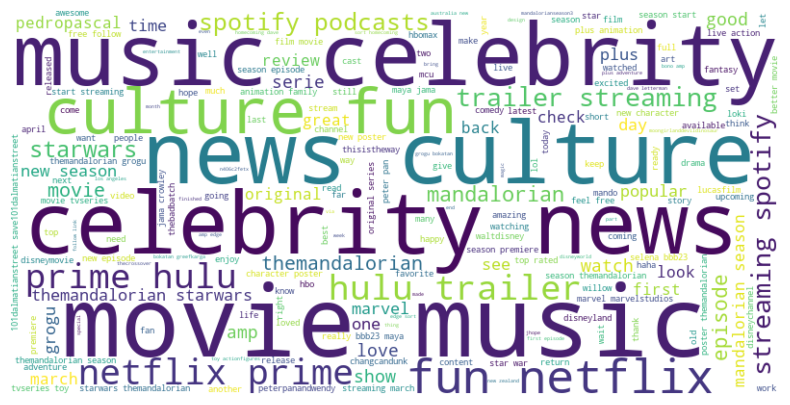

In [62]:
corpus_lda = preprocess_tweets(positive_tweets)
generate_wordCloud(corpus_lda)

### 2. For negative Tweets

In [63]:
kmeans_topic_modelling(negative_tweets['tweet_cleaned_new'])

Topic 0:
['marvel', 'movie', 'streaming', 'amp', 'netflix', 'new', 'movies', 'like', 'black', 'mcu']
Topic 1:
['batch', 'bad batch', 'wars', 'bad', 'star wars', 'wars bad', 'star', 'thebadbatch', 'starwars', 'episode']
Topic 2:
['starwars', 'themandalorian', 'mandalorian', 'season', 'starwars https', 'grogu', 'episode', 'series', 'bad', 'review']


In [64]:
lda_topic_modelling(negative_tweets)

Topic 0:
mandalorian, themandalorian, season, marvel, starwars, series, way, episode, grogu, one
Topic 1:
woke, amp, starwars, peterpanandwendy, youtube, peter, pan, review, trailer, race
Topic 2:
starwars, bad, batch, episode, star, war, mandalorian, season, thebadbatch, starwarsthebadbatch


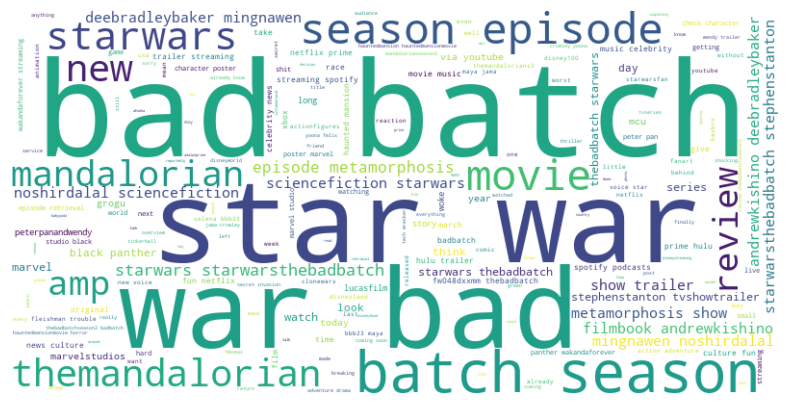

In [65]:
corpus_lda = preprocess_tweets(negative_tweets)
generate_wordCloud(corpus_lda)

### 3. For neutral tweets:

In [66]:
kmeans_topic_modelling(neutral_tweets['tweet_cleaned_new'])

Topic 0:
['appletv', 'hbomax', 'hbomax hulu', 'hulu netflix', 'netflix primevideo', 'appletv hbomax', 'primevideo', 'netflix', 'week', 'hulu']
Topic 1:
['themandalorian', 'starwars', 'mandalorian', 'season', 'marvel', 'grogu', 'day', '30', 'marvelstudios', 'streaming']
Topic 2:
['bex https', 'review bex', 'bex', 'review', 'disney100', 'youtube', 'disneyplushotstarth', 'days', 'days 41', 'devil']


In [67]:
lda_topic_modelling(neutral_tweets)

Topic 0:
day, hotstar, disneyplushotstarth, acc, hulu, movie, fd2cczr0wx, disneyplustr, 2023, disneytva
Topic 1:
themandalorian, starwars, mandalorian, grogu, season, mando, pedropascal, thisistheway, watch, way
Topic 2:
marvel, disney100, mcu, marvelstudios, bex, animation, review, devil, avenger, marvelcomics


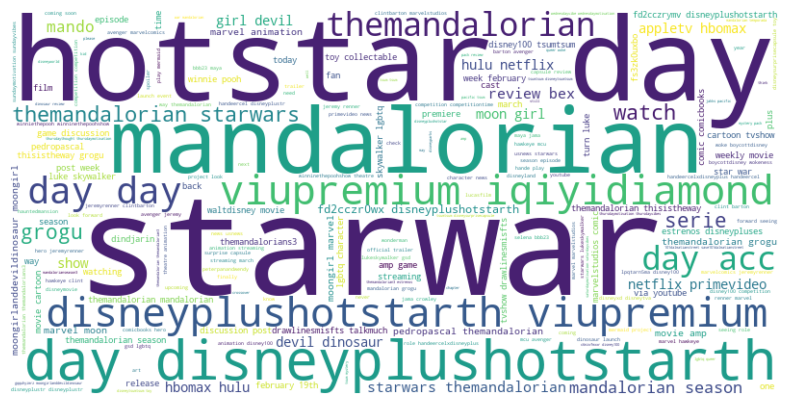

In [68]:
corpus_lda = preprocess_tweets(neutral_tweets)
generate_wordCloud(corpus_lda)

As per all above results, it is quiet evident that **The Mandalorian** is the most discussed topic throughout the time frame

## Further Analysis of major topic discussed throughout about the release of 'The Mandalorian" Series on 1st March, 2023 for which we see a huge spike in tweets on 2nd March 2023

In [69]:
df['hour'] = df['created_at'].dt.hour
df.date = pd.to_datetime(df.date)
tweets_on_march_2_2023 = df[df['date'] == '2023-03-02']

#Sort the DataFrame by influence score in descending order
tweets_on_march_2_2023_sorted = tweets_on_march_2_2023.sort_values(by='influence_score_retweet_fav', ascending=False)

# Select the top 5 influencers
top_10_influential_tweets_on_2_March = tweets_on_march_2_2023_sorted.head(10)

# Print the top 5 influencers
print("Top 10 influential tweets on 2nd March:")
#print(top_5_influencers[['author_id', 'followers_count', 'retweet_count', 'favorite_count']])
top_10_influential_tweets_on_2_March.head(10)

Top 10 influential tweets on 2nd March:


,author_id,statuses_count,location,verified,followers_count,friends_count,listed_count,tweets_or_status_favorited_count,tweet_id,text,...,retweet_count,hashtags,favorite_count,tweet_cleaned_new,sentiment_score,sentiment,date,influence_score_retweet_fav,count_hashtags,hour
2116,4019049327,2344,chester uk,False,3814,295,26,4288,1631276547263934464,"Grogu's spinning chair, from the Mandalorian s...",...,750,"[{'text': 'LEGO', 'indices': [66, 71]}, {'text...",6330,grogu spinning chair mandalorian season 3 epis...,0.000000,Neutral,2023-03-02,7080,7,12
1959,985916593065476096,42477,worldwide,True,5215338,266,6611,3012,1631357530810253312,The journey continues. \n\nChapter 17 of #TheM...,...,98,"[{'text': 'TheMandalorian', 'indices': [39, 54...",956,journey continues chapter 17 themandalorian st...,0.000000,Neutral,2023-03-02,1054,2,18
1933,985916593065476096,42477,worldwide,True,5215338,266,6611,3012,1631370034416340992,"When ball is life, every move matters. \n\n#Th...",...,71,"[{'text': 'TheCrossover', 'indices': [41, 54]}...",450,ball life every move matters thecrossover orig...,0.375000,Positive,2023-03-02,521,2,19
1939,985916593065476096,42477,worldwide,True,5215338,266,6611,3012,1631368781988782080,"In the game of life, know who’s on your team.\...",...,69,"[{'text': 'TheCrossover', 'indices': [47, 60]}...",383,game life know team thecrossover original seri...,-0.012500,Negative,2023-03-02,452,2,19
2254,25407190,186,usa,True,1485,137,17,237,1631165754392608768,This showed up at the #MoonGirlAndDevilDinosau...,...,39,"[{'text': 'MoonGirlAndDevilDinosaur', 'indices...",200,showed moongirlanddevildinosaur offices today ...,0.200000,Positive,2023-03-02,239,4,5
2063,1163978074200956930,3861,back to the roots (or future),False,1267,190,4,14287,1631298993777958913,I think some of Dolly's beta collars are looki...,...,41,"[{'text': '101Dalmatianstreet', 'indices': [10...",159,think dolly beta collars looking nice dolly th...,0.600000,Positive,2023-03-02,200,9,14
2124,146028353,5593,mandalore,False,2359,112,48,1798,1631272066849857536,Mando\nI love his new N1\nLet me know what you...,...,20,"[{'text': 'starwars', 'indices': [51, 60]}, {'...",153,mando love new n1 let know think starwars them...,0.318182,Positive,2023-03-02,173,13,12
2019,1122048163253088257,1031,los angeles,False,1434,202,31,32,1631329218268364801,Top 10 Disney+ tv shows by online activity yes...,...,30,"[{'text': 'TheMandalorian', 'indices': [70, 85...",142,top 10 disney tv shows online activity yesterd...,0.425000,Positive,2023-03-02,172,14,16
2014,1426293770123980803,138,NaN,False,235,67,0,391,1631330971076161537,I realized that I've never draw deepak and tha...,...,42,"[{'text': '101DalmatianStreet', 'indices': [88...",104,realized never draw deepak unacceptable 101dal...,0.000000,Neutral,2023-03-02,146,5,16
2032,928864728,18649,supporting scott worldwide,False,1477,416,21,510,1631323421778001922,I seriously just wanna wake up one day real so...,...,17,"[{'text': 'TheOrville', 'indices': [63, 74]}, ...",79,seriously wan na wake one day real soon words ...,0.000000,Neutral,2023-03-02,96,4,15


Topic 0:
['trailer', 'peterpanandwendy', 'new', 'pan', 'peter', 'peter pan', 'wendy', 'amp', 'hauntedmansion', 'like']
Topic 1:
['streaming', 'marvel', 'hulu', 'movie', 'netflix', '30', 'movies', 'day', 'mcu', 'hotstar']
Topic 2:
['themandalorian', 'starwars', 'mandalorian', 'grogu', 'season', 'mando', 'starwars https', 'episode', 'themandalorians3', 'themandalorian starwars']


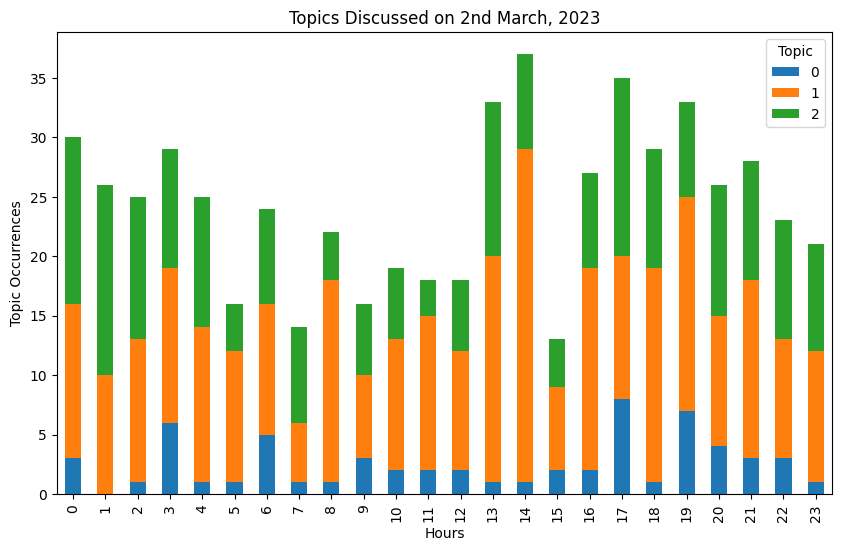

In [70]:
influencer_corpus_Kmeans = tweets_on_march_2_2023_sorted['tweet_cleaned_new']

stop_words = ['http', 'co', 'disney', 'disneyplus']  # Specified the words to remove
vectorizer = TfidfVectorizer(lowercase=True, max_features=100, max_df=0.8, min_df=2, ngram_range=(1, 2), stop_words=stop_words)
vectors = vectorizer.fit_transform(influencer_corpus_Kmeans)

model = KMeans(n_clusters = 3, init= 'k-means++',n_init=1, random_state=42)

model.fit(vectors)

# Get the centroids
centroids = model.cluster_centers_

# Sort the centroids indices
order_centroids = centroids.argsort()[:, ::-1]

# Get the feature names
terms = vectorizer.get_feature_names_out()
for i in range(3):
    print(f"Topic {i}:")
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(top_terms)

# Assign topics to tweets based on closest centroids
tweet_topics = model.predict(vectors)

# Add topic information to DataFrame
tweets_on_march_2_2023_sorted['topic'] = tweet_topics

# Aggregate by day and count topic occurrences
topic_counts_by_day = tweets_on_march_2_2023_sorted.groupby(['hour', 'topic']).size().unstack(fill_value=0)

# Plot the results
topic_counts_by_day.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Hours')
plt.ylabel('Topic Occurrences')
plt.title('Topics Discussed on 2nd March, 2023')
plt.legend(title='Topic')
plt.show()

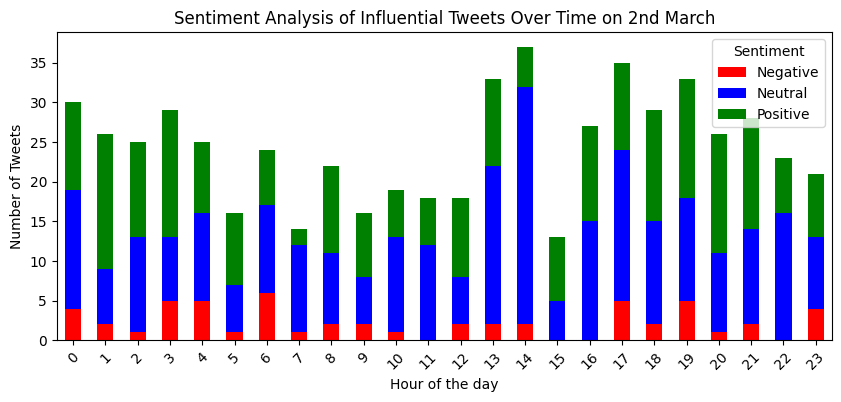

In [71]:
sentiment_of_influential_tweets = tweets_on_march_2_2023.groupby(['hour', 'sentiment']).size().unstack(fill_value=0)

colors = ['red','blue', 'green', ]

sentiment_of_influential_tweets.plot(kind='bar', stacked=True, figsize=(10, 4), color = colors)
plt.title('Sentiment Analysis of Influential Tweets Over Time on 2nd March')
plt.xlabel('Hour of the day')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
# plt.show()

In [72]:
# Count tweets containing '@Disneyplus' or '@disneyplus'
tweets_with_disneyplus = tweets_on_march_2_2023[tweets_on_march_2_2023['text'].str.contains('@Disneyplus|@disneyplus|@DisneyPlus', case=False)]

# Get the count of tweets containing '@Disneyplus' or '@disneyplus'
len(tweets_with_disneyplus)

47

# C. Segementing the twitter users

### **Analysing all the twitter users**

In [73]:
unique_author_ids = df['author_id'].unique().tolist()

In [74]:
influencer_dict = {}

def get_sentiment_val(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

for i in unique_author_ids:
    tweets_by_author = df[df['author_id'] == i]
    df1 = tweets_by_author.head(1)
    no_of_tweets = len(tweets_by_author)
    is_verified = df1['verified'].iloc[0]
    no_of_followers = int(df1['followers_count'].iloc[0])
    no_of_days_active = tweets_by_author.date.nunique()
    no_of_retweets = tweets_by_author.retweet_count.sum()
    no_of_favourites = tweets_by_author.favorite_count.sum()
    no_of_hashtags = tweets_by_author.count_hashtags.sum()
    user_sentiment = tweets_by_author.sentiment_score.mean()
  
    influencer_dict[i] = {
        'author_id' : i,
        'no_of_followers': no_of_followers,
        'is_verified' : is_verified,
        'no_of_tweets': no_of_tweets,
        'no_of_days_active': no_of_days_active,
        'no_of_retweets': no_of_retweets,
        'no_of_favourites': no_of_favourites,
        'no_of_hashtags': no_of_hashtags,
        'user_sentiment_score': user_sentiment,
        'user_sentiment': get_sentiment_val(user_sentiment)
    }

df_influencers_all = pd.DataFrame.from_dict(influencer_dict, orient='index')
df_influencers_all['engagement_rate'] = (df_influencers_all['no_of_retweets'] + df_influencers_all['no_of_favourites']) / df_influencers_all['no_of_followers']
df_influencers_all.reset_index(drop=True, inplace=True)
df_influencers_all.set_index('author_id', inplace=True)
df_influencers_all.head()

,no_of_followers,is_verified,no_of_tweets,no_of_days_active,no_of_retweets,no_of_favourites,no_of_hashtags,user_sentiment_score,user_sentiment,engagement_rate
author_id,,,,,,,,,,
1552675995081183233,118,False,4,2,38,129,28,0.116667,Positive,1.415254
723532208179404800,765,False,36,7,0,4,210,0.093441,Positive,0.005229
1613354669161566208,60,False,1,1,1,11,3,-0.231818,Negative,0.200000
1590931714024607745,193,False,87,6,4,32,120,0.473397,Positive,0.186528
40831879,1530,False,1,1,0,0,1,0.350000,Positive,0.000000


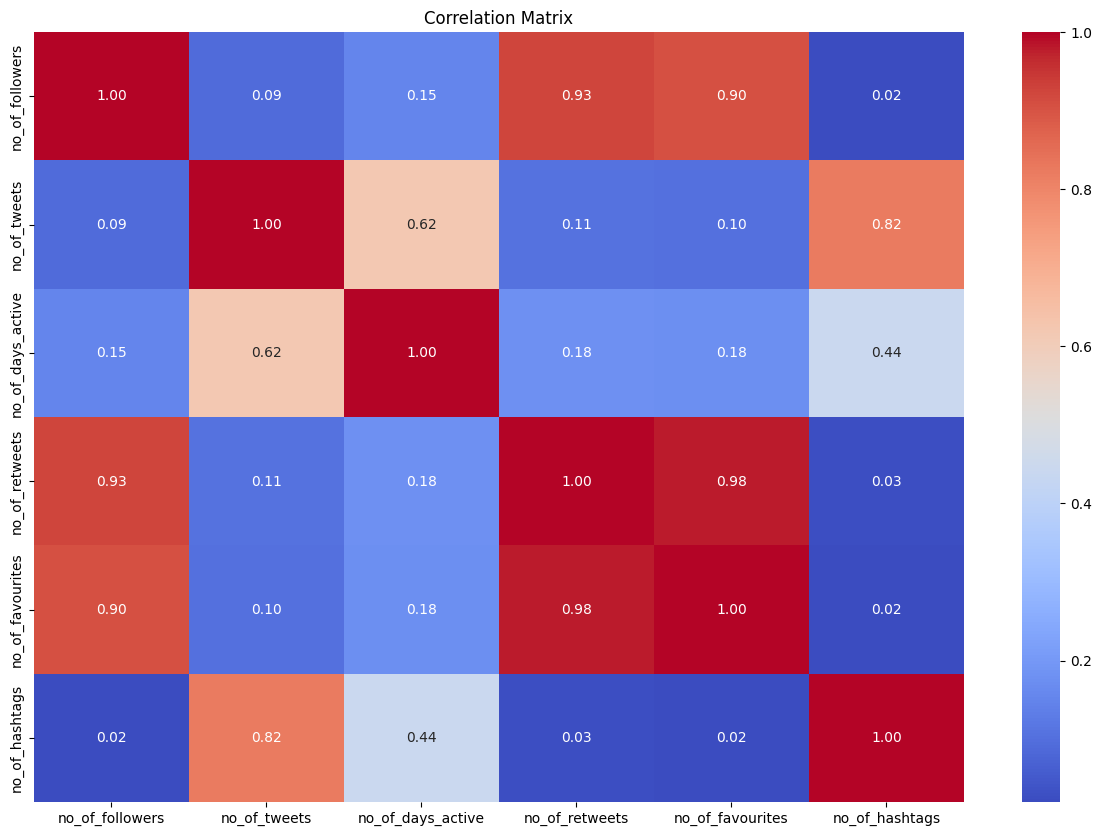

In [75]:
req_df = df_influencers_all.copy()
req_df1 = df_influencers_all.copy()
req_df.drop(columns = ['is_verified','user_sentiment','user_sentiment_score','engagement_rate'], inplace= True)
req_df1.drop(columns = ['is_verified','user_sentiment','user_sentiment_score'], inplace= True)

data = req_df

import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix = data.corr(numeric_only = True)

# Set up the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

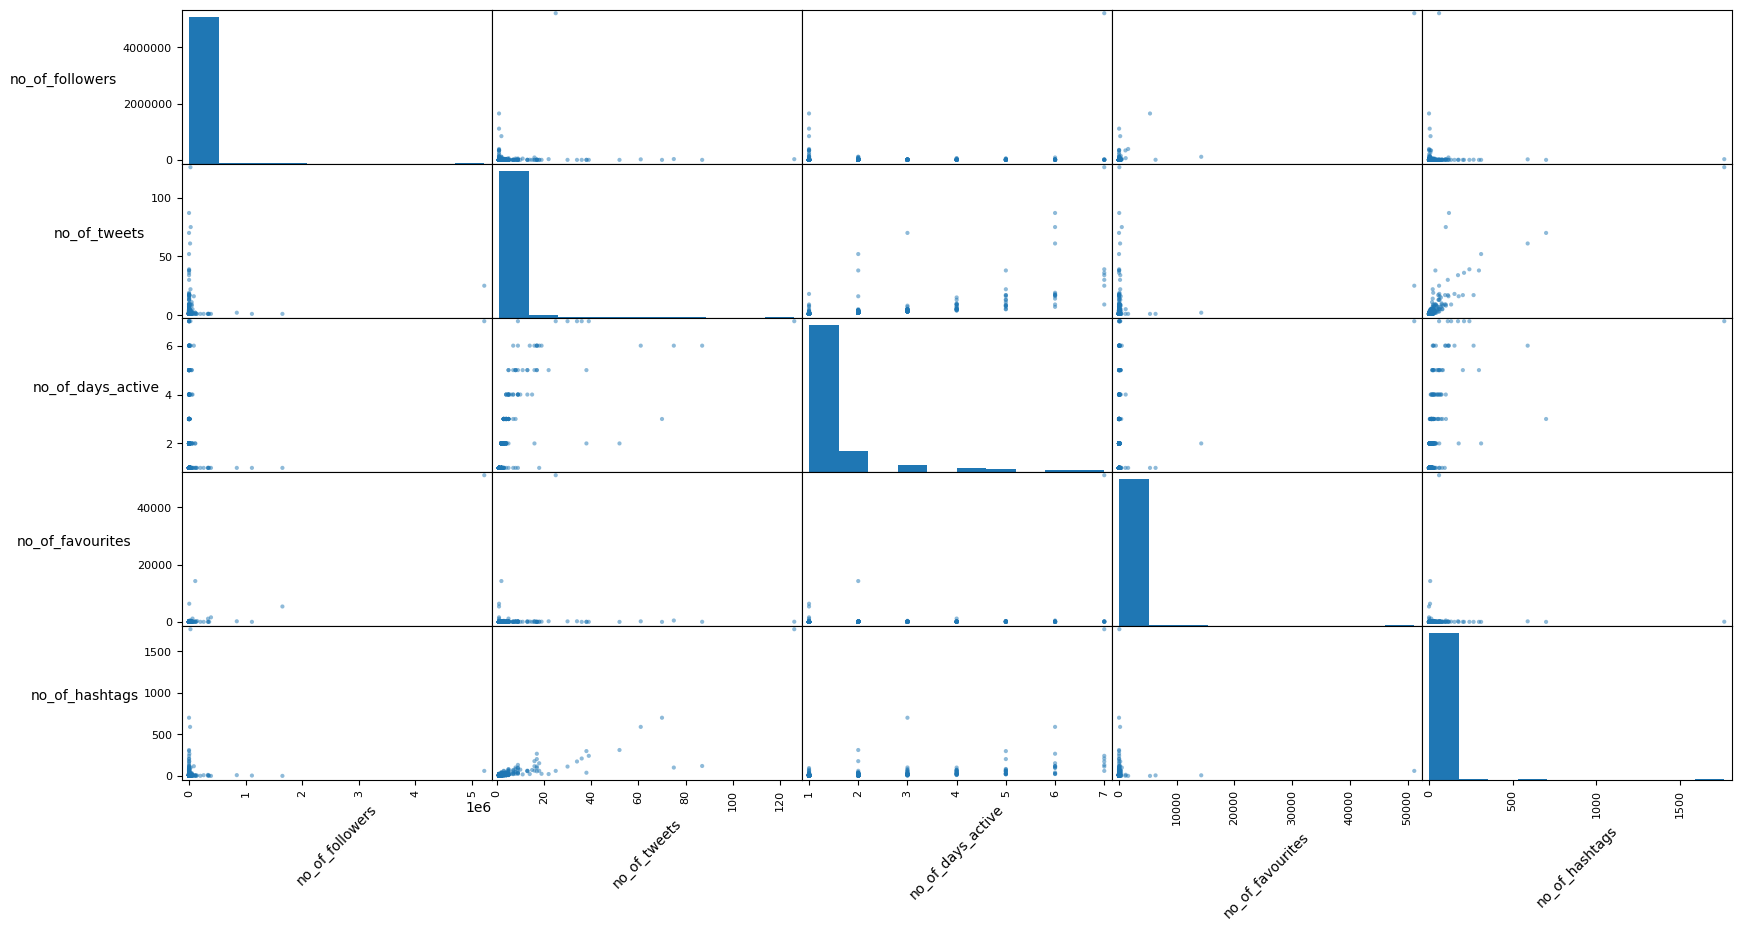

In [76]:
data.drop(columns=['no_of_retweets'], inplace=True)  #dropping this column due to very high correlation

scatter = pd.plotting.scatter_matrix(data, figsize = (20,10))
for ax in scatter.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

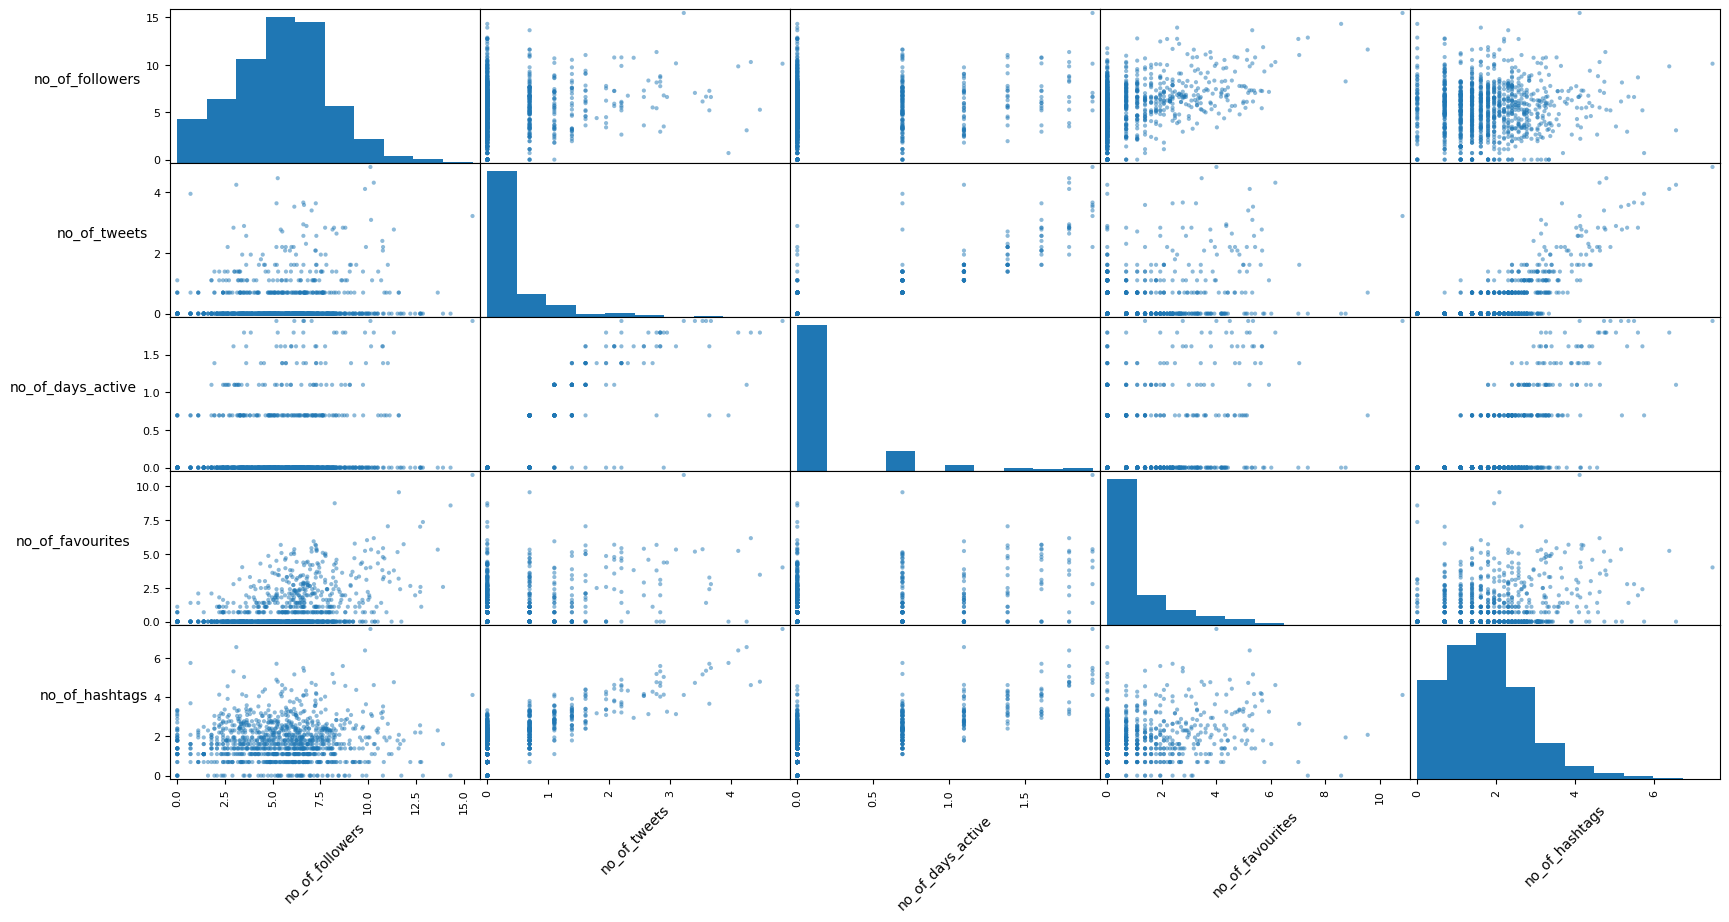

In [77]:
data = data.replace(0, 1)

for col in data.select_dtypes(include=['int64', 'float64']).columns:
    min_value = data[col].min()
    data[col] = np.where(data[col] < 0, 1, data[col])
# Scale the data using the natural logarithm
logged_data = np.log(data)

#-- Produce a scatter matrix using the logged data...
scatter = pd.plotting.scatter_matrix(logged_data, figsize = (20,10))
# Rotate x-axis labels by 45 degrees and keep y-axis labels horizontal
for ax in scatter.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')  # Horizontal alignment

In [78]:
import sklearn

from sklearn.decomposition import PCA

#-- Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=3)
pca.fit(logged_data)

PCA(n_components=3)

             no_of_followers  no_of_tweets  no_of_days_active  \
Dimension 1         0.939694      0.059171           0.034067   
Dimension 2        -0.299430      0.341925           0.196833   
Dimension 3         0.164889      0.336306           0.185568   

             no_of_favourites  no_of_hashtags  
Dimension 1          0.332543        0.041570  
Dimension 2          0.700973        0.513149  
Dimension 3         -0.626972        0.657404  
Explained variance of each component: [0.68411665 0.19415208 0.10036463]
Cumulative explained variance: [0.68411665 0.87826873 0.97863336]


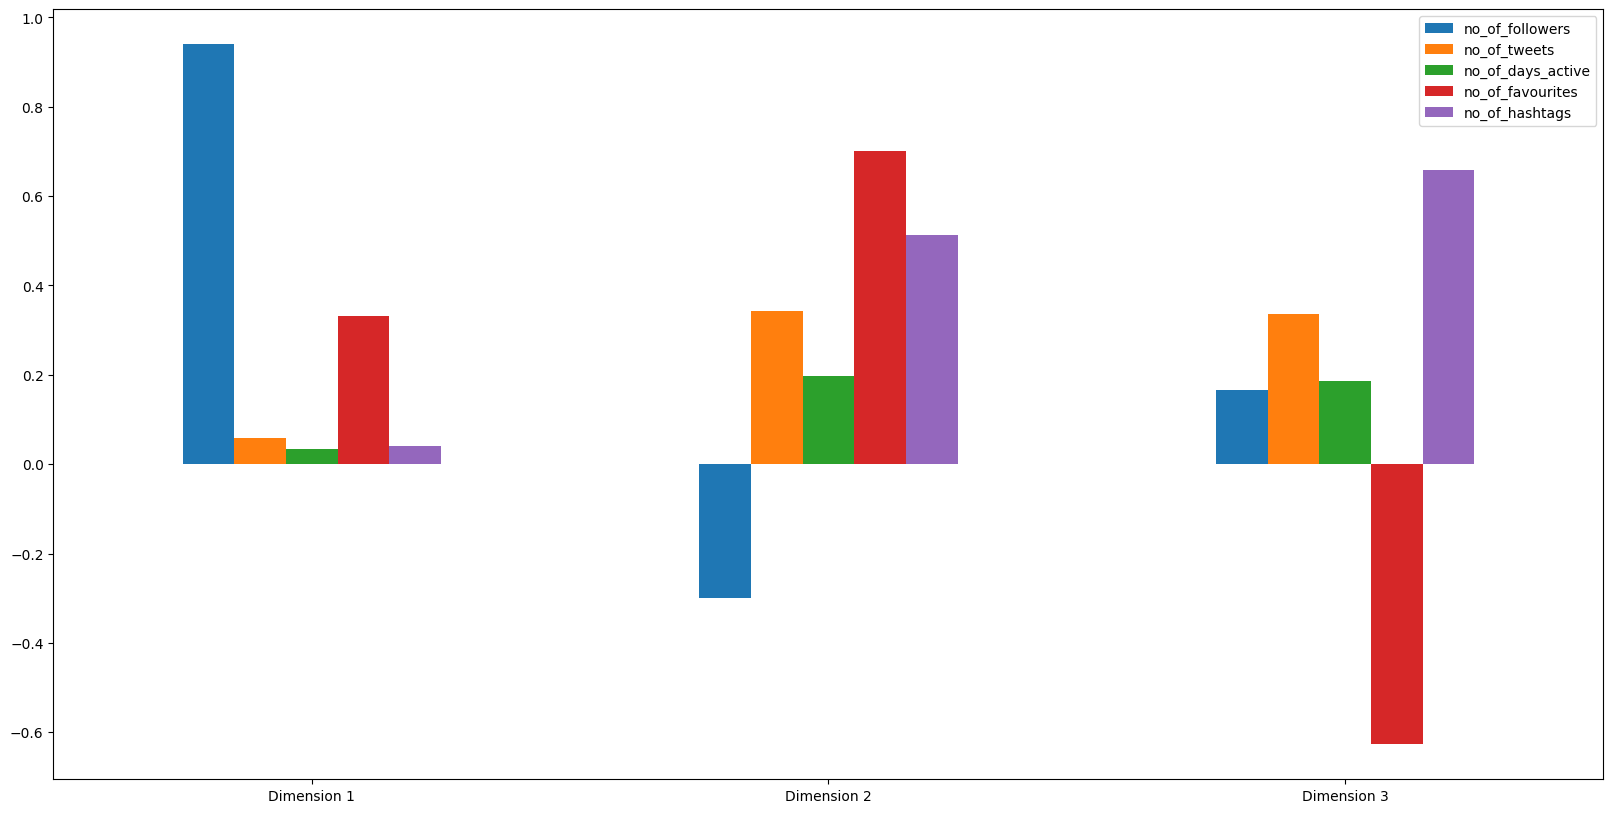

In [79]:
pca_results= pd.DataFrame(data= pca.fit(logged_data).components_, columns= data.columns, index= ['Dimension 1', 'Dimension 2', 'Dimension 3'])
print(pca_results)

#-- Generate a PCA results bar plot
ax = pca_results.plot.bar(figsize=(20, 10))
ax.tick_params(axis='x', rotation=0)

#-- Print out the explained variance of each component, as well as cumulatively
explained_variance = pca.explained_variance_ratio_
print('Explained variance of each component:', explained_variance)
print('Cumulative explained variance:', np.cumsum(explained_variance))

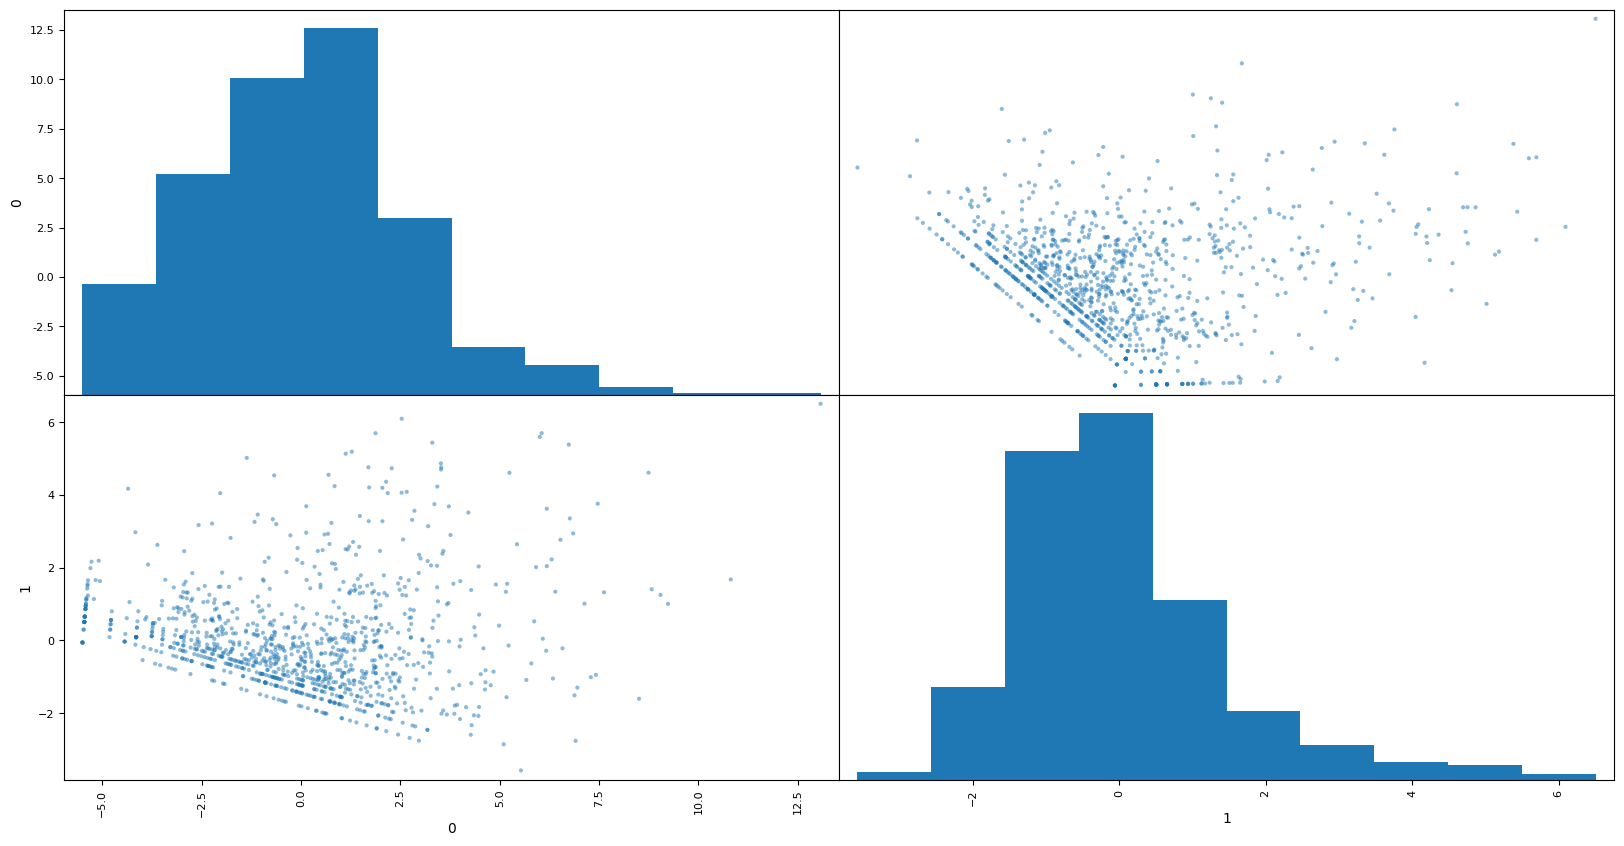

In [80]:
pca = PCA(n_components=2)
pca.fit(logged_data)

# TO DO: Transform the good data using the PCA fit above
reduced_data = pca.transform(logged_data)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data)
scatter = pd.plotting.scatter_matrix(reduced_data, figsize = (20,10))

C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\

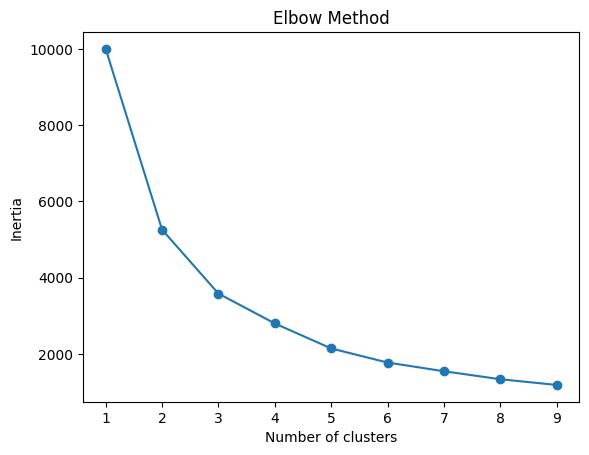

In [81]:
inertia = []
for n_clusters in range(1, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reduced_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


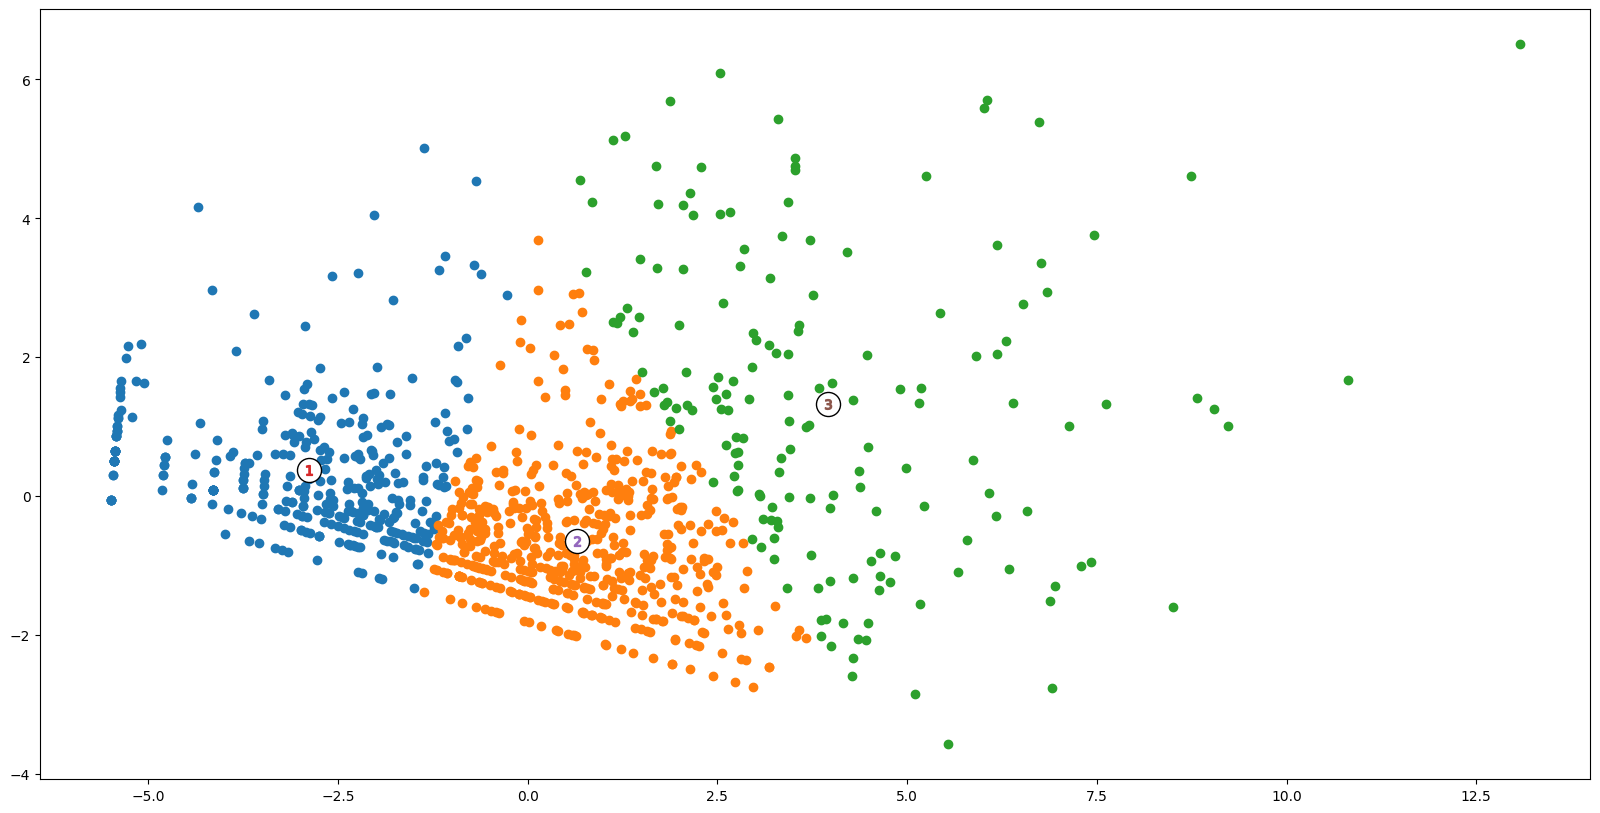

In [82]:
import random

# Set a fixed random seed
random_seed = 42 
np.random.seed(random_seed)
random.seed(random_seed)

#-- Our final clustering solution
clusterer = KMeans(n_clusters=3).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centres = clusterer.cluster_centers_

# Add 1 to cluster labels to start numbering from 1
preds += 1

#-- Put the predictions into a pandas dataframe format
assignments = pd.DataFrame(preds, columns = ['Cluster'])

#-- Put the predictions into a pandas dataframe format
plot_data = pd.concat([assignments, reduced_data], axis = 1)

#-- Color the points based on assigned cluster (n.b scatter will do this for us automatically)
plt.rcParams['figure.figsize'] = (20,10)

for i, c in plot_data.groupby('Cluster'):
    plt.scatter(c[0], c[1])

#-- Plot where the cluster centers are
for i, c in enumerate(centres):
    plt.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', marker = 'o', s=300);
    plt.scatter(x = c[0], y = c[1], marker='${}$'.format(i+1), alpha = 1, s=50);

In [83]:
# TO DO: Inverse transform the centres
log_centres = pca.inverse_transform(centres)

# TO DO: Exponentiate the centres
true_centres = np.exp(log_centres)

#-- Display the true centres
segments = ['Segment {}'.format(i+1) for i in range(0, len(centres))]
true_centres = pd.DataFrame(np.round(true_centres), columns = data.columns)
true_centres.index = segments
true_centres

,no_of_followers,no_of_tweets,no_of_days_active,no_of_favourites,no_of_hashtags
Segment 1,14.0,1.0,1.0,1.0,6.0
Segment 2,513.0,1.0,1.0,2.0,4.0
Segment 3,6280.0,3.0,2.0,23.0,14.0


In [84]:
req_df1.reset_index(inplace=True)
final_assigments = pd.concat([assignments, req_df1], axis = 1)
final_assigments

,Cluster,author_id,no_of_followers,no_of_tweets,no_of_days_active,no_of_retweets,no_of_favourites,no_of_hashtags,engagement_rate
0,3,1552675995081183233,118,4,2,38,129,28,1.415254
1,3,723532208179404800,765,36,7,0,4,210,0.005229
2,1,1613354669161566208,60,1,1,1,11,3,0.200000
3,3,1590931714024607745,193,87,6,4,32,120,0.186528
4,2,40831879,1530,1,1,0,0,1,0.000000
...,...,...,...,...,...,...,...,...,...
1068,2,1159305147941564416,1368,1,1,0,8,3,0.005848
1069,1,836370767411621888,86,1,1,0,0,6,0.000000
1070,2,2854274943,1636,1,1,0,1,3,0.000611
1071,2,1205333521394479104,618,1,1,0,0,6,0.000000


In [85]:
#-- Join the segment assignments to the original data
final_assigments = pd.concat([assignments, req_df1], axis = 1)

#-- Create a loop that describes summary statistics for each segment
for c, d in final_assigments.groupby('Cluster'):
    print("Segment", c)
    display(d.describe())

Segment 1


C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Cluster,author_id,no_of_followers,no_of_tweets,no_of_days_active,no_of_retweets,no_of_favourites,no_of_hashtags,engagement_rate
count,356.0,3.560000e+02,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,337.000000
mean,1.0,1.242287e+18,25.247191,1.870787,1.286517,0.407303,1.176966,12.632022,inf
std,0.0,5.179501e+17,23.253911,4.811973,0.736905,1.472701,3.953195,43.242871,NaN
min,1.0,1.969276e+07,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1.0,1.169846e+18,6.000000,1.000000,1.000000,0.000000,0.000000,3.000000,0.000000
50%,1.0,1.491059e+18,18.500000,1.000000,1.000000,0.000000,0.000000,5.000000,0.000000
75%,1.0,1.580179e+18,38.000000,1.000000,1.000000,0.000000,1.000000,11.000000,0.090909
max,1.0,1.631466e+18,94.000000,70.000000,6.000000,19.000000,56.000000,700.000000,inf


Segment 2


,Cluster,author_id,no_of_followers,no_of_tweets,no_of_days_active,no_of_retweets,no_of_favourites,no_of_hashtags,engagement_rate
count,548.0,5.480000e+02,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,2.0,5.277486e+17,1046.341241,1.317518,1.177007,0.624088,2.854015,7.237226,0.013602
std,0.0,6.102644e+17,1683.793893,1.054937,0.533743,1.627327,6.643758,9.137499,0.057026
min,2.0,6.058942e+06,74.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,2.0,2.926827e+08,201.000000,1.000000,1.000000,0.000000,0.000000,3.000000,0.000000
50%,2.0,3.023238e+09,488.000000,1.000000,1.000000,0.000000,1.000000,5.000000,0.001047
75%,2.0,1.156148e+18,1090.500000,1.000000,1.000000,0.000000,3.000000,8.000000,0.007636
max,2.0,1.620574e+18,15937.000000,15.000000,5.000000,13.000000,73.000000,81.000000,0.935897


Segment 3


,Cluster,author_id,no_of_followers,no_of_tweets,no_of_days_active,no_of_retweets,no_of_favourites,no_of_hashtags,engagement_rate
count,169.0,1.690000e+02,1.690000e+02,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,3.0,5.332844e+17,8.000301e+04,6.846154,2.278107,124.556213,538.810651,40.775148,0.086517
std,0.0,6.265612e+17,4.341018e+05,15.140218,1.832135,1192.887807,4117.017311,148.175279,0.248786
min,3.0,8.211930e+05,1.180000e+02,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,3.0,1.122900e+08,1.267000e+03,1.000000,1.000000,2.000000,7.000000,4.000000,0.000674
50%,3.0,2.575635e+09,4.679000e+03,2.000000,1.000000,5.000000,27.000000,10.000000,0.005272
75%,3.0,1.183158e+18,2.364800e+04,5.000000,3.000000,17.000000,90.000000,26.000000,0.050926
max,3.0,1.621493e+18,5.215334e+06,126.000000,7.000000,15453.000000,51165.000000,1764.000000,1.856319


# D. Identifying the micro-influencer

In [86]:
df_influencers_all['influence_score_retweet_fav'] = df_influencers_all['no_of_retweets'] + df_influencers_all['no_of_favourites']
df_influencers_sorted = df_influencers_all.sort_values(by='influence_score_retweet_fav', ascending=False)
df_influencers_sorted.head(10)

,no_of_followers,is_verified,no_of_tweets,no_of_days_active,no_of_retweets,no_of_favourites,no_of_hashtags,user_sentiment_score,user_sentiment,engagement_rate,influence_score_retweet_fav
author_id,,,,,,,,,,,
985916593065476096,5215334,True,25,7,15453,51165,61,0.064801,Positive,0.012773,66618
1488626051194490881,110059,False,2,2,1181,14246,8,0.000000,Neutral,0.140170,15427
4019049327,3814,False,1,1,750,6330,7,0.000000,Neutral,1.856319,7080
18847632,1649547,True,1,1,835,5368,1,0.308036,Positive,0.003760,6203
25140900,387789,True,1,1,245,1579,1,0.308036,Positive,0.004704,1824
21113724,61728,True,5,4,135,1152,14,0.200000,Positive,0.020850,1287
906213869042917377,335861,True,1,1,115,1115,2,0.237500,Positive,0.003662,1230
1060664640122863616,29554,False,75,6,90,479,101,0.074358,Positive,0.019253,569
1284939145522089984,20734,False,1,1,98,413,5,0.128788,Positive,0.024646,511


#### Filtering out users with less than 300000 followers

In [87]:
df_influencers = df_influencers_all.copy()
df_influencers['engagement_rate'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Filter records with finite engagement rates
filtered_data = df_influencers.dropna(subset=['engagement_rate'])
filtered_data = df_influencers[df_influencers['no_of_followers'] > 300000]


# Rank users based on engagement rate
ranked_data = filtered_data.sort_values(by='engagement_rate', ascending=False)

# Select top-ranked users as micro-influencers
micro_influencers_based_on_followers = ranked_data.head(40)
micro_influencers_based_on_followers

,no_of_followers,is_verified,no_of_tweets,no_of_days_active,no_of_retweets,no_of_favourites,no_of_hashtags,user_sentiment_score,user_sentiment,engagement_rate,influence_score_retweet_fav
author_id,,,,,,,,,,,
985916593065476096,5215334,True,25,7,15453,51165,61,0.064801,Positive,0.012773,66618
25140900,387789,True,1,1,245,1579,1,0.308036,Positive,0.004704,1824
18847632,1649547,True,1,1,835,5368,1,0.308036,Positive,0.003760,6203
906213869042917377,335861,True,1,1,115,1115,2,0.237500,Positive,0.003662,1230
226835223,843679,True,2,1,70,205,10,0.280000,Positive,0.000326,275
35203319,341242,False,1,1,5,13,9,0.166667,Positive,0.000053,18
34396109,334341,True,1,1,0,9,13,0.000000,Neutral,0.000027,9
19383317,355751,True,1,1,3,3,2,0.136364,Positive,0.000017,6
15375209,1110932,True,1,1,1,13,5,0.300000,Positive,0.000013,14


### From above it is evident that author '985916593065476096' is the micro-influencer for DisneyPlus with highest no. of followers, active for all 7 days, and tweeting 25 tweets in the time frame. Moreover, higher no. of retweets and favourites have been received to the author's tweets indicating people are engaging with the authors content posted. Thus, this one is our influencer.

In [88]:
author_data = final_assigments[final_assigments['author_id'] == 985916593065476096]
if not author_data.empty:
    # Get the cluster segment for the author_id
    segment = author_data.iloc[0]['Cluster']  # Assuming 'Cluster' is the column containing cluster segments
    
    # Print the segment for the author_id
    print(f"Author ID 985916593065476096 is present in segment {segment}.")
else:
    # If no data exists for the author_id, print a message
    print("Author ID 985916593065476096 is not present in any segment.")

Author ID 985916593065476096 is present in segment 3.0.


Also, this influencer is present in the segment 3 of users

## Analysis of the micro-influencer

This user has highest followers, favourite and retweet counts. - 985916593065476096 is the Micro-influencer

#### **Tweets by micro-influencer**

In [89]:
tweets_by_micro_influencer = df[df['author_id'] == 985916593065476096]
tweets_by_micro_influencer = tweets_by_micro_influencer.sort_values(by='influence_score_retweet_fav', ascending=False) #influence score is sum of fav+retweet count
tweets_by_micro_influencer[['text', 'favorite_count', 'retweet_count', 'sentiment']]

,text,favorite_count,retweet_count,sentiment
991,"Only 🫰🫰🫰 for #jhope.\n\nj-hope IN THE BOX, a d...",35065,13539,Positive
2538,Don’t miss the return of #TheMandalorian. \n\n...,2662,328,Neutral
735,New character posters for #TheMandalorian and ...,1934,255,Positive
1257,Easily the most versatile of kitchen cookware....,1395,91,Positive
1303,“There’s something dangerous happening out the...,1206,142,Negative
1959,The journey continues. \n\nChapter 17 of #TheM...,956,98,Neutral
80,The clan of two. 🥹\n\nCatch up on #TheMandalor...,887,116,Positive
969,Check out these character posters from Marvel ...,865,77,Negative
734,New character posters for #TheMandalorian and ...,694,80,Positive
733,New character posters for #TheMandalorian and ...,529,63,Positive


#### 1. **Most popular tweet of micro-influencer**

In [90]:
most_favourite_tweet = tweets_by_micro_influencer.nlargest(1, 'influence_score_retweet_fav')

# Print the result
print("Tweet with the maximum count of favourite and retweets:")
max_favourite_tweet

Tweet with the maximum count of favourite and retweets:


,author_id,statuses_count,location,verified,followers_count,friends_count,listed_count,tweets_or_status_favorited_count,tweet_id,text,...,lang,retweet_count,hashtags,favorite_count,tweet_cleaned_new,sentiment_score,sentiment,date,influence_score_retweet_fav,count_hashtags
991,985916593065476096,42477,worldwide,True,5215336,266,6611,3012,1629934324035518464,"Only 🫰🫰🫰 for #jhope.\n\nj-hope IN THE BOX, a d...",...,en,13539,"[{'text': 'jhope', 'indices': [13, 19]}, {'tex...",35065,jhope j hope box documentary special streaming...,0.178571,Positive,2023-02-26,48604,2


##### **2. Applying LDA to check topics discused in tweets by micro-influencer**

In [91]:
influencer_corpus = preprocess_tweets(tweets_by_micro_influencer)

lda_topic_modelling(tweets_by_micro_influencer)

Topic 0:
themandalorian, new, season, march, streaming, start, character, poster, bokatan, grogu
Topic 1:
streaming, wakandaforever, marvel, poster, character, check, panther, studio, black, original
Topic 2:
streaming, series, april, original, life, thecrossover, h7ocduk82m, team, easily, tn5iax7eth


##### **2. Using KMeans & TF-IDF to check topics (bi-grams)**

In [92]:
influencer_corpus_Kmeans = tweets_by_micro_influencer['tweet_cleaned_new']

# Step 2: Tokenization and Vectorization
stop_words = ['http', 'co', 'disney', 'disneyplus']  # Specify the words to remove
vectorizer = TfidfVectorizer(lowercase=True, max_features=100, max_df=0.8, min_df=2, ngram_range=(1, 2), stop_words=stop_words)
vectors = vectorizer.fit_transform(influencer_corpus_Kmeans)

# Step 3: Apply KMeans with KMeans++ initialization
model = KMeans(n_clusters = 3, init= 'k-means++',n_init=1, random_state=42)

model.fit(vectors)

# Get the centroids
centroids = model.cluster_centers_

# Sort the centroids indices
order_centroids = centroids.argsort()[:, ::-1]

# Get the feature names
terms = vectorizer.get_feature_names_out()
for i in range(3):
    print(f"Topic {i}:")
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(top_terms)

# Assign topics to tweets based on closest centroids
tweet_topics = model.predict(vectors)

# Add topic information to DataFrame
tweets_by_micro_influencer['topic'] = tweet_topics

Topic 0:
['new', 'themandalorian', 'season', 'new season', 'march', 'stream', 'season themandalorian', 'march https', 'streaming march', 'starts']
Topic 1:
['wakandaforever streaming', 'studios', 'black', 'black panther', 'check', 'check character', 'marvel studios', 'panther', 'panther wakandaforever', 'posters marvel']
Topic 2:
['streaming', 'streaming https', 'chapter', 'chapter 17', 'april', 'april https', 'original series', 'thecrossover original', 'thecrossover', 'series']


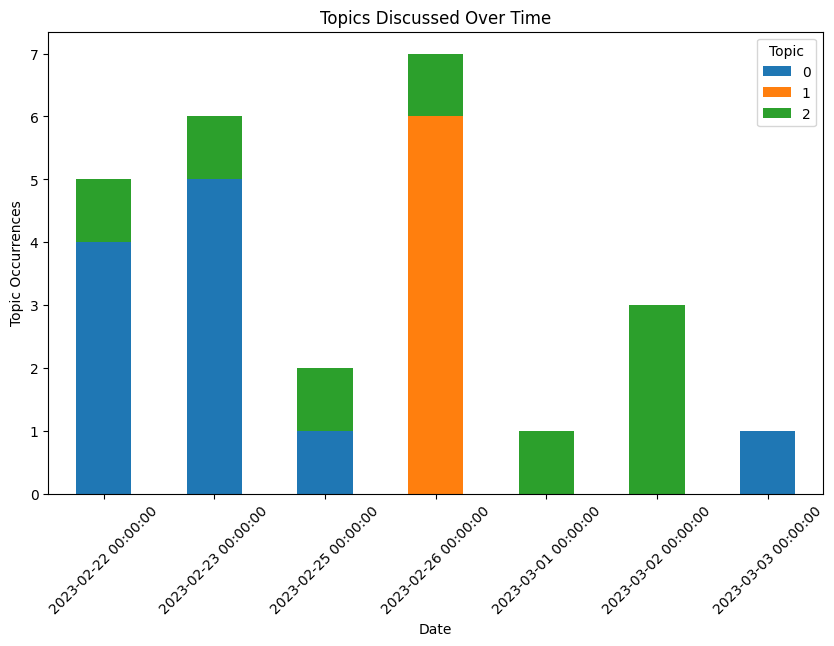

In [93]:
# Aggregate by day and count topic occurrences
topic_counts_by_day = tweets_by_micro_influencer.groupby(['date', 'topic']).size().unstack(fill_value=0)
# topic_counts_by_day.plot(kind='bar', stacked=True, figsize=(10, 6))
# plt.xlabel('Date')
# plt.ylabel('Topic Occurrences')
# plt.title('Topics Discussed on Each Day')
# plt.legend(title='Topic')
# plt.xticks(rotation=30)

# plt.show()
topic_counts_by_day.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Topic Occurrences')
plt.title('Topics Discussed Over Time')
plt.legend(title='Topic')
plt.xticks(rotation=45)
plt.show()

Using Kmeans &TF-IDF we get a better idea about the topics being discussed by the micro-influencer than LDA

#### 3. **Word cloud for influencer**

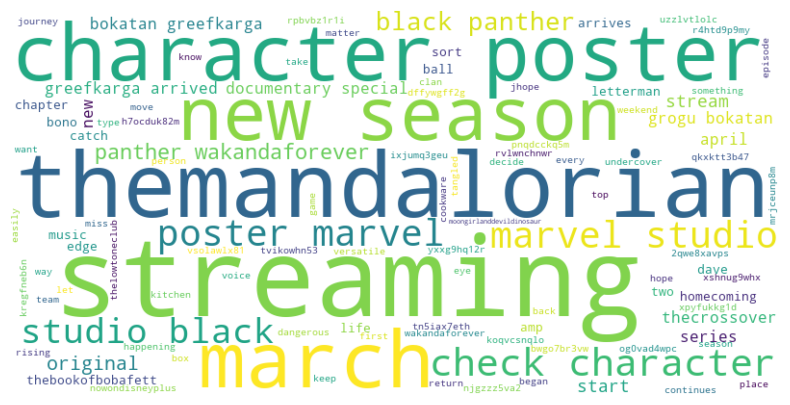

In [94]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def remove_specific_words(corpus, words_to_remove):
    filtered_corpus = []
    for document in corpus:
        filtered_document = [word for word in document if word not in words_to_remove]
        filtered_corpus.append(filtered_document)
    return filtered_corpus

words_to_remove = ['https', 'co', 'disney', 'disneyplus']
    
# Assuming `influencer_corpus` is a list of lists of words representing your text data
influencer_corpus = remove_specific_words(influencer_corpus, words_to_remove)

# Flatten the list of lists into a single list of words
flat_influencer_corpus = [word for sublist in influencer_corpus for word in sublist]

# Combine all text into a single string
text = ' '.join(flat_influencer_corpus)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=10).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### On further check, it is found that this user is the **official Disney plus account**

**Since it is the official disney account, it can't be considered as a influencer account.**

The rest of the users among the top 10 influencers have good no. of followers and influence rate, however they have made comparitively lesser tweets mostly a single tweet. Thus, different criteria needs to be checked to identify influencer. We will consider only the influential rate for the users for now which is sum of favourites and retweets.

## Micro-influencer by definition:

***A micro-influencer is an influencer with a follower count within the range of 10,000–100,000 followers.***

In [95]:
# Assuming df_influencers_all has a column named 'no_of_followers'
selected_influencers = df_influencers_all[(df_influencers_all['no_of_followers'] >= 10000) & (df_influencers_all['no_of_followers'] <= 100000)]
selected_influencers.sort_values(by='engagement_rate', ascending=False).head(5)

,no_of_followers,is_verified,no_of_tweets,no_of_days_active,no_of_retweets,no_of_favourites,no_of_hashtags,user_sentiment_score,user_sentiment,engagement_rate,influence_score_retweet_fav
author_id,,,,,,,,,,,
17188547,10897,False,1,1,59,320,2,0.583333,Positive,0.034780,379
1284939145522089984,20734,False,1,1,98,413,5,0.128788,Positive,0.024646,511
21113724,61728,True,5,4,135,1152,14,0.200000,Positive,0.020850,1287
218812313,18687,False,61,6,187,187,590,0.016393,Positive,0.020014,374
1060664640122863616,29554,False,75,6,90,479,101,0.074358,Positive,0.019253,569


From above analysis, we can see that author '21113724' is one being more active by posting 5 tweets in four days and have good amount of engagement with 1152 favourites and 135 total retweets being made. 

## Other way, sorting the authors based on the amount of retweet and favourites recieved:

In [96]:
influential_users = df_influencers_all.sort_values(by='influence_score_retweet_fav', ascending=False)
influential_users.head(10)

,no_of_followers,is_verified,no_of_tweets,no_of_days_active,no_of_retweets,no_of_favourites,no_of_hashtags,user_sentiment_score,user_sentiment,engagement_rate,influence_score_retweet_fav
author_id,,,,,,,,,,,
985916593065476096,5215334,True,25,7,15453,51165,61,0.064801,Positive,0.012773,66618
1488626051194490881,110059,False,2,2,1181,14246,8,0.000000,Neutral,0.140170,15427
4019049327,3814,False,1,1,750,6330,7,0.000000,Neutral,1.856319,7080
18847632,1649547,True,1,1,835,5368,1,0.308036,Positive,0.003760,6203
25140900,387789,True,1,1,245,1579,1,0.308036,Positive,0.004704,1824
21113724,61728,True,5,4,135,1152,14,0.200000,Positive,0.020850,1287
906213869042917377,335861,True,1,1,115,1115,2,0.237500,Positive,0.003662,1230
1060664640122863616,29554,False,75,6,90,479,101,0.074358,Positive,0.019253,569
1284939145522089984,20734,False,1,1,98,413,5,0.128788,Positive,0.024646,511


Here as well, author **21113724** seems like a better choice with having posted more frequently than the others with more influence score than him. Obviously, the first position is taken here by the official disney account.

In [97]:
tweets_by_new_influencer = df[df['author_id'] == 21113724]
tweets_by_new_influencer = tweets_by_new_influencer.sort_values(by='influence_score_retweet_fav', ascending=False) #influence score is sum of fav+retweet count
tweets_by_new_influencer[['text', 'favorite_count', 'retweet_count', 'sentiment']]

,text,favorite_count,retweet_count,sentiment
1053,Check out the awesome #TheMandalorian outdoor ...,707,103,Positive
1332,4 days to #TheMandalorian Season 3 on #DisneyP...,144,13,Neutral
675,Mouse character posters #TheMandalorian #BoKat...,134,10,Neutral
866,The global phenomenon returns in just over a w...,116,7,Neutral
1949,The Global Phenomenon returns #TheMandalorian ...,51,2,Neutral


Here, we have considered  the author with id **21113724** as second possible inluencer. The reasons are- the person has tweeted for 4 days out of 7 active days and tweeted 5 times. The overall sentiment is positive along with that, the no. of followers is quite descent. In 5 tweets user has utilized 14 hashtags, trying to get better reach. Also for just 5 tweets the person has gained  1152 favourites and 135 retweets meaning people are trying to engage with the content posted by the user.

# Comparing the new influencer with the user who have made maximum tweets

In [98]:
most_active_user = df_influencers_all.nlargest(1, 'no_of_tweets')

# Print the result
print("Most active user:")
most_active_user

Most active user:


,no_of_followers,is_verified,no_of_tweets,no_of_days_active,no_of_retweets,no_of_favourites,no_of_hashtags,user_sentiment_score,user_sentiment,engagement_rate,influence_score_retweet_fav
author_id,,,,,,,,,,,
1534870262679748609,24793,False,126,7,5,55,1764,0.234651,Positive,0.00242,60


The author has 24,793 followers and has been active on all 7 days. However, the engagement to the tweets received is very low, with only 55 favourites and 5 retweets for all 126 tweets made. If further information about when the person has joined twitter was available then we can get a better idea that if the person is a new user, probably has a good prospect of being a influencer as per his online activity.